In [202]:
import matplotlib.pyplot as plt
import math
import cv2
import numpy as np
import pickle
from collections import deque, Counter
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
import shutil
import os
from glob import glob
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [203]:

def show_inline(img, title="Image"):
    plt.figure(figsize=(10, 10))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()
def detect_board_contour(img, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("No contours found!")
        return None

    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    output_img = img.copy()

    for i, cnt in enumerate(contours[:3]):
        hull = cv2.convexHull(cnt)
        
        hull_pts = hull[:, 0, :]

        sum_pts = hull_pts.sum(axis=1)
        tl_idx = np.argmin(sum_pts)
        
        br_idx = np.argmax(sum_pts)
        
        diff_pts = np.diff(hull_pts, axis=1)
        tr_idx = np.argmin(diff_pts)
        
        bl_idx = np.argmax(diff_pts)

        corners = np.array([hull_pts[tl_idx], hull_pts[tr_idx], hull_pts[br_idx], hull_pts[bl_idx]])

        detected_area = cv2.contourArea(corners)
        
        if detected_area > 50000: 
            
            cv2.drawContours(output_img, [hull], -1, (255, 0, 0), 2)
            
            for point in corners:
                cv2.circle(output_img, tuple(point), 20, (0, 0, 255), -1)
            
            cv2.drawContours(output_img, [corners.reshape(-1, 1, 2)], -1, (0, 255, 0), 2)
            
            
            return corners.reshape(4, 2)

    print("Could not find a large board.")
    return None
def detect_board(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    b_channel = lab[:, :, 2] 
    blur = cv2.GaussianBlur(b_channel, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 21, 2)
    
    
    _, mask = cv2.threshold(blur, 0, 255,cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    mask = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    largest_contour = detect_board_contour(img, mask)
    return largest_contour
    

In [204]:

ref_board = cv2.imread('help/ref_pb.jpg')

def detect_game_components(img):
    map_contour_result = detect_board(img)
    main_board_area = cv2.contourArea(map_contour_result)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    blur = cv2.bilateralFilter(gray, 9, 75, 75)
    
    edged = cv2.Canny(blur, 30, 100)
    
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edged, kernel, iterations=2)
    if map_contour_result is not None:
        board_cnt = map_contour_result.astype(np.int32)

        margin_thickness = int(0.05 * np.sqrt(main_board_area)) 

        cv2.drawContours(dilated, [board_cnt], -1, 0, thickness=margin_thickness)
        
        cv2.drawContours(dilated, [board_cnt], -1, 0, thickness=-1)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    player_board_contours = []
    remaining_contours = contours.copy()

    
    if map_contour_result is None:
        print("Could not detect the Main Map.")
        return img, None, []

    min_player_area = main_board_area * 0.05
    max_player_area = main_board_area * 0.70
    debug_img = img.copy()
    if remaining_contours:
        for c in remaining_contours:
            cv2.drawContours(debug_img, [c], -1, (0, 255, 255), 2)
            hull = cv2.convexHull(c)
            peri = cv2.arcLength(hull, True)
            
            approx = cv2.approxPolyDP(hull, 0.04 * peri, True)
            area = cv2.contourArea(hull)

            if len(approx) == 4 and min_player_area < area < max_player_area:
                M = cv2.moments(approx)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    
                    player_board_contours.append(approx)
    

    return img, map_contour_result, player_board_contours

res,map_conts,player_conts = detect_game_components(cv2.imread('maps/mapa21.jpg'))
for pc in player_conts:
    cv2.drawContours(res, [pc], -1, (255, 0, 0), 4)
cv2.drawContours(res, [map_conts], -1, (0, 255, 0), 4)

array([[[122, 137, 146],
        [100, 115, 124],
        [ 86, 101, 110],
        ...,
        [ 67,  71,  76],
        [ 65,  69,  74],
        [ 64,  68,  73]],

       [[118, 133, 142],
        [ 98, 113, 122],
        [ 88, 103, 112],
        ...,
        [ 68,  72,  77],
        [ 66,  70,  75],
        [ 65,  69,  74]],

       [[112, 127, 136],
        [ 96, 111, 120],
        [ 91, 106, 115],
        ...,
        [ 68,  72,  77],
        [ 67,  71,  76],
        [ 66,  70,  75]],

       ...,

       [[ 75,  86,  90],
        [ 74,  85,  89],
        [ 73,  84,  88],
        ...,
        [  2,   0,   0],
        [  6,   1,   2],
        [  9,   4,   5]],

       [[ 74,  85,  89],
        [ 73,  84,  88],
        [ 72,  83,  87],
        ...,
        [  2,   0,   0],
        [  4,   0,   0],
        [  6,   1,   2]],

       [[ 73,  84,  88],
        [ 72,  83,  87],
        [ 71,  82,  86],
        ...,
        [  2,   0,   0],
        [  4,   0,   0],
        [  4,   0,   0]]

In [205]:

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)] 
    rect[2] = pts[np.argmax(s)] 
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)] 
    rect[3] = pts[np.argmax(diff)] 
    return rect

def auto_correct_orientation(img):
    best_img = img
    max_score = -1
    best_angle = 0
    
    h, w = img.shape[:2]
    roi_y1, roi_y2 = int(h * 0.62), int(h * 0.84)
    roi_x1, roi_x2 = int(w * 0.80), int(w * 0.95)
    
    for angle in [0, 90, 180, 270]:
        rotated = img.copy()
        if angle == 90:
            rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        elif angle == 180:
            rotated = cv2.rotate(img, cv2.ROTATE_180)
        elif angle == 270:
            rotated = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
            
        roi = rotated[roi_y1:roi_y2, roi_x1:roi_x2]
        hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        
        lower_blue = np.array([90, 50, 50])
        upper_blue = np.array([130, 255, 255])
        mask = cv2.inRange(hsv_roi, lower_blue, upper_blue)
        
        score = cv2.countNonZero(mask)
        
        
        if score > max_score:
            max_score = score
            best_img = rotated
            best_angle = angle

    return best_img

def isolate_score_track(img, board_contour):
    if img is None or board_contour is None:
        print("Missing input data.")
        return None, None

    rect = order_points(board_contour.reshape(4, 2))
    warped_size = 1000
    dst = np.array([
        [0, 0],
        [warped_size - 1, 0],
        [warped_size - 1, warped_size - 1],
        [0, warped_size - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (warped_size, warped_size))
    
    warped = auto_correct_orientation(warped)

    inner_ratio = 46 / 52
    margin_percentage = (1.0 - inner_ratio) / 2.0
    margin_px = int(warped_size * margin_percentage)

    mask = np.zeros((warped_size, warped_size), dtype="uint8")
    
    cv2.rectangle(mask, (0, 0), (warped_size, warped_size), 255, -1)
    
    cv2.rectangle(mask,
                  (margin_px, margin_px),
                  (warped_size - margin_px, warped_size - margin_px),
                  0, -1)

    track_only = cv2.bitwise_and(warped, warped, mask=mask)

    
    return track_only, warped




In [206]:

def crop_floor_by_lab(image):
    if image is None: return None
    
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    b_channel = lab[:, :, 2] 
    blur = cv2.GaussianBlur(b_channel, (5, 5), 0)
    target_percentile = 90    
    dynamic_thresh_val = np.percentile(blur, target_percentile)
    
    
    thresh = cv2.threshold(blur, dynamic_thresh_val, 255, cv2.THRESH_BINARY)[1]
    _, mask = cv2.threshold(blur, 0, 255,cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return mask
        



In [207]:

def refine_mask(mask):

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    valid_contours = [c for c in contours if cv2.contourArea(c) > 30]
    
    if not valid_contours:
        print("No contours found.")
        return opened

    rects = []
    centers = []
    for c in valid_contours:
        x, y, w, h = cv2.boundingRect(c)
        rects.append((x, y, w, h))
        centers.append([x + w//2, y + h//2])

    all_dims = [r[2] for r in rects] + [r[3] for r in rects]
    median_side = np.median(all_dims)
    median_area = np.median([r[2]*r[3] for r in rects])

    centers = np.array(centers)
    if len(centers) > 1:
        diffs = centers[:, np.newaxis, :] - centers[np.newaxis, :, :]
        dists = np.sqrt(np.sum(diffs**2, axis=-1))
        
        np.fill_diagonal(dists, np.inf)
        
        nearest_dists = np.min(dists, axis=1)
        median_pitch = np.median(nearest_dists)
    else:
        median_pitch = median_side * 1.2 


    final_mask = opened.copy()
    median_width = np.median([r[2] for r in rects])
    median_height = np.median([r[3] for r in rects])
    for c in valid_contours:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)
        
        if area < 0.45 * median_area:
            cv2.drawContours(final_mask, [c], -1, 0, -1)
            continue
        
        if area > 1.5 * median_area:
            
            if w > h: 
                count = int(round(w / median_pitch))
                count = max(2, count)
                
                step = w / count
                for i in range(1, count):
                    split_x = int(x + (i * step))
                    cv2.line(final_mask, (split_x, y), (split_x, y+h), 0, thickness=4)
                    
            else:
                count = int(round(h / median_pitch))
                count = max(2, count)
                
                step = h / count
                for i in range(1, count):
                    split_y = int(y + (i * step))
                    cv2.line(final_mask, (x, split_y), (x+w, split_y), 0, thickness=4)
        if w < 0.6 * median_width or h < 0.6 * median_height:
            cv2.drawContours(final_mask, [c], -1, 0, -1)
            continue    
    return final_mask



In [208]:
def repair_mask(image_path_or_array, total_pads=100):
    if isinstance(image_path_or_array, str):
        img = cv2.imread(image_path_or_array, cv2.IMREAD_GRAYSCALE)
    else:
        img = image_path_or_array

    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    repaired_mask = thresh.copy()
    debug_vis = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    all_areas = [cv2.contourArea(c) for c in contours]
    if not all_areas: return img, debug_vis
    median_area = np.median(all_areas)

    pad_rects = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w * h > (0.2 * median_area): 
            pad_rects.append({'cx': x + w//2, 'cy': y + h//2, 'w': w, 'h': h})

    if not pad_rects: return img, debug_vis

    all_cx = [p['cx'] for p in pad_rects]
    all_cy = [p['cy'] for p in pad_rects]

    def find_peaks(coords, tolerance):
        bins = []
        for val in coords:
            found_bin = False
            for b in bins:
                if abs(np.mean(b) - val) < tolerance:
                    b.append(val)
                    found_bin = True
                    break
            if not found_bin:
                bins.append([val])
        
        sorted_bins = sorted(bins, key=len, reverse=True)
        
        if len(sorted_bins) < 2:
            return min(coords), max(coords) 
            
        peak1 = int(np.mean(sorted_bins[0]))
        peak2 = int(np.mean(sorted_bins[1]))
        
        return sorted([peak1, peak2]) 

    median_w = np.median([p['w'] for p in pad_rects])
    median_h = np.median([p['h'] for p in pad_rects])

    rail_left, rail_right = find_peaks(all_cx, median_w)
    rail_top, rail_bottom = find_peaks(all_cy, median_h)


    tl = (rail_left,  rail_top)
    tr = (rail_right, rail_top)
    br = (rail_right, rail_bottom)
    bl = (rail_left,  rail_bottom)

    pads_per_side = int(total_pads / 4) + 1 
    ideal_points = []

    def get_linspace(start_pt, end_pt, count):
        pts = []
        for i in range(count):
            t = i / (count - 1)
            x = int(start_pt[0] + (end_pt[0] - start_pt[0]) * t)
            y = int(start_pt[1] + (end_pt[1] - start_pt[1]) * t)
            pts.append((x, y))
        return pts

    ideal_points.extend(get_linspace(tl, tr, pads_per_side))       
    ideal_points.extend(get_linspace(tr, br, pads_per_side)[1:])  
    ideal_points.extend(get_linspace(br, bl, pads_per_side)[1:])   
    ideal_points.extend(get_linspace(bl, tl, pads_per_side)[1:-1]) 

    pads_drawn = 0
    draw_w = int(median_w - 2)
    draw_h = int(median_h - 2)

    for (ix, iy) in ideal_points:
        match_found = False
        for p in pad_rects:
            if abs(p['cx'] - ix) < (median_w / 1.5) and abs(p['cy'] - iy) < (median_h / 1.5):
                match_found = True
                break
        
        if not match_found:
            tl_x = int(ix - draw_w // 2)
            tl_y = int(iy - draw_h // 2)
            cv2.rectangle(repaired_mask, (tl_x, tl_y), (tl_x + draw_w, tl_y + draw_h), 255, -1)
            cv2.rectangle(debug_vis, (tl_x, tl_y), (tl_x + draw_w, tl_y + draw_h), (0, 255, 0), -1)
            pads_drawn += 1
    
    return repaired_mask, debug_vis

In [209]:

def process_chip_grid(original_img_path, mask_img_path):
     original = original_img_path
     vis = original.copy()
     mask = mask_img_path
     _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
     contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
     
     pads = []
     for c in contours:
         x, y, w, h = cv2.boundingRect(c)
         if w * h > 50: 
            pads.append({'x': x, 'y': y, 'w': w, 'h': h, 'cx': x + w//2, 'cy': y + h//2, 'real': True})
     if pads:
         pads.sort(key=lambda p: p['cx']) 
         med_w = np.median([p['w'] for p in pads])
         med_h = np.median([p['h'] for p in pads])
     all_cx = [p['cx'] for p in pads]
     all_cy = [p['cy'] for p in pads]
     grid_cx = np.mean(all_cx)
     grid_cy = np.mean(all_cy)
     for p in pads:
         p['angle'] = math.atan2(p['cy'] - grid_cy, p['cx'] - grid_cx)
     pads.sort(key=lambda p: p['angle'])
     dist_to_tl = [p['cx'] + p['cy'] for p in pads]
     start_index = np.argmin(dist_to_tl)
     ordered_pads = pads[start_index:] + pads[:start_index]
     yellow_group = []
     orange_group = []
     for i, p in enumerate(ordered_pads):
         x, y, w, h = p['x'], p['y'], p['w'], p['h']
         is_yellow = (i % 5 == 0)
         if is_yellow:
             yellow_group.append(p)
             color = (0, 255, 255) 
             thick = 3
             roi = original[y:y+h, x:x+w]
         else:
             orange_group.append(p)
             color = (0, 165, 255) 
             thick = 1

 
     return vis, ordered_pads




In [210]:
def normalize_board_colors_robust(original_img, pad_data):
    normalized_img = original_img.copy()
    count = len(pad_data)

    hsv_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)

    for i, p in enumerate(pad_data):
        if i % 5 != 0:
            continue
            
        prev_idx = (i - 1) % count
        next_idx = (i + 1) % count
        prev_pad = pad_data[prev_idx]
        next_pad = pad_data[next_idx]

        roi_prev = original_img[prev_pad['y']:prev_pad['y']+prev_pad['h'], prev_pad['x']:prev_pad['x']+prev_pad['w']]
        roi_next = original_img[next_pad['y']:next_pad['y']+next_pad['h'], next_pad['x']:next_pad['x']+next_pad['w']]

        if roi_prev.size == 0 or roi_next.size == 0: continue

        color_prev = np.median(roi_prev, axis=(0,1)).astype(np.uint8)
        color_next = np.median(roi_next, axis=(0,1)).astype(np.uint8)
        target_orange_bgr = np.mean([color_prev, color_next], axis=0).astype(np.uint8)

        x, y, w, h = p['x'], p['y'], p['w'], p['h']
        roi_bgr = normalized_img[y:y+h, x:x+w]
        roi_hsv = hsv_img[y:y+h, x:x+w] 

        if roi_bgr.size == 0: continue

        lower_yellow = np.array([10, 20, 60])  
        upper_yellow = np.array([35, 255, 255]) 

        bg_mask = cv2.inRange(roi_hsv, lower_yellow, upper_yellow)
        
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        bg_mask = cv2.morphologyEx(bg_mask, cv2.MORPH_OPEN, kernel, iterations=1)

        if cv2.countNonZero(bg_mask) < (w * h * 0.1):
            lower_relaxed = np.array([10, 5, 40]) 
            bg_mask = cv2.inRange(roi_hsv, lower_relaxed, upper_yellow)

        roi_bgr[bg_mask == 255] = target_orange_bgr

        normalized_img[y:y+h, x:x+w] = roi_bgr

    return normalized_img



In [211]:

def detect_anomalies_top_n(original_img, pad_data, neighbor_count=3, top_n=5):
    vis = original_img.copy()

    for p in pad_data:
        x, y, w, h = p['x'], p['y'], p['w'], p['h']
        roi = original_img[y+2:y+h-2, x+2:x+w-2] 
        
        if roi.size > 0:
            mean_bgr = np.mean(roi, axis=(0,1))
            p['hsv'] = cv2.cvtColor(np.uint8([[mean_bgr]]), cv2.COLOR_BGR2HSV)[0][0]
        else:
            p['hsv'] = np.array([0, 0, 0])

    all_scored_pads = []
    count = len(pad_data)

    for i, pad in enumerate(pad_data):
        current_color = pad['hsv'].astype(float)
        
        neighbors_hsv = []
        for offset in range(1, neighbor_count + 1):
            prev_idx = (i - offset) % count
            next_idx = (i + offset) % count
            neighbors_hsv.append(pad_data[prev_idx]['hsv'].astype(float))
            neighbors_hsv.append(pad_data[next_idx]['hsv'].astype(float))
        
        local_mean = np.mean(neighbors_hsv, axis=0)
        
        diff_h = abs(current_color[0] - local_mean[0])
        diff_s = abs(current_color[1] - local_mean[1])
        diff_v = abs(current_color[2] - local_mean[2])
        
        diff_h = min(diff_h, 180 - diff_h)

        w_h, w_s, w_v = 4.0, 1.0, 0.5
        
        deviation_score = math.sqrt((diff_h * w_h)**2 + (diff_s * w_s)**2 + (diff_v * w_v)**2)
        
        pad['deviation'] = deviation_score
        all_scored_pads.append(pad)

    all_scored_pads.sort(key=lambda x: x['deviation'], reverse=True)
    top_guesses = all_scored_pads[:top_n]

    for rank, p in enumerate(top_guesses):
        x, y, w, h = p['x'], p['y'], p['w'], p['h']
        score = p['deviation']
        
        
        cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 0, 255), 3)
        label = f"#{rank+1} ({int(score)})"
        cv2.putText(vis, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
    
    return vis, top_guesses

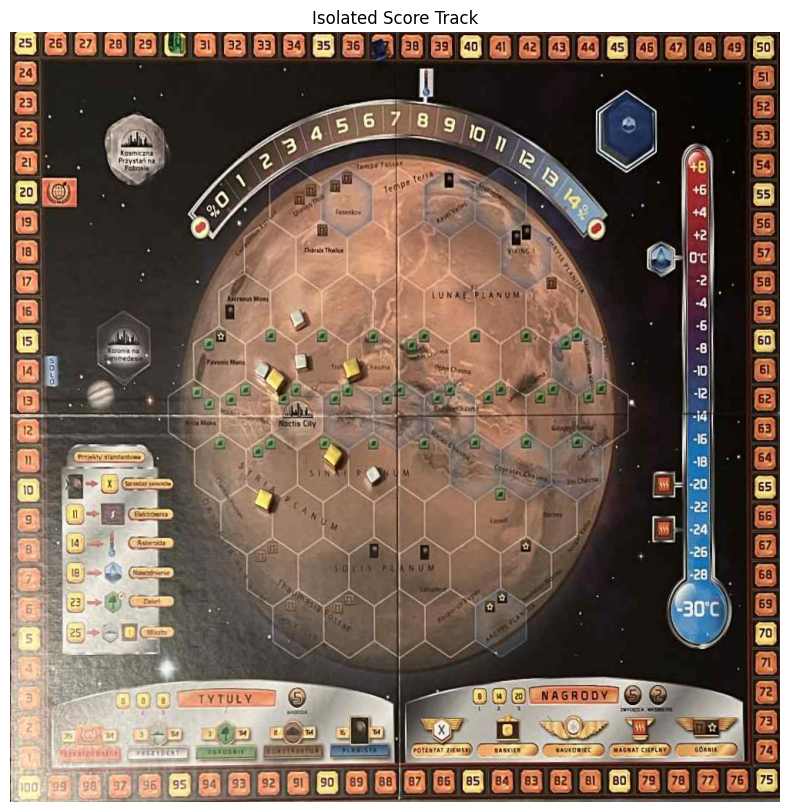

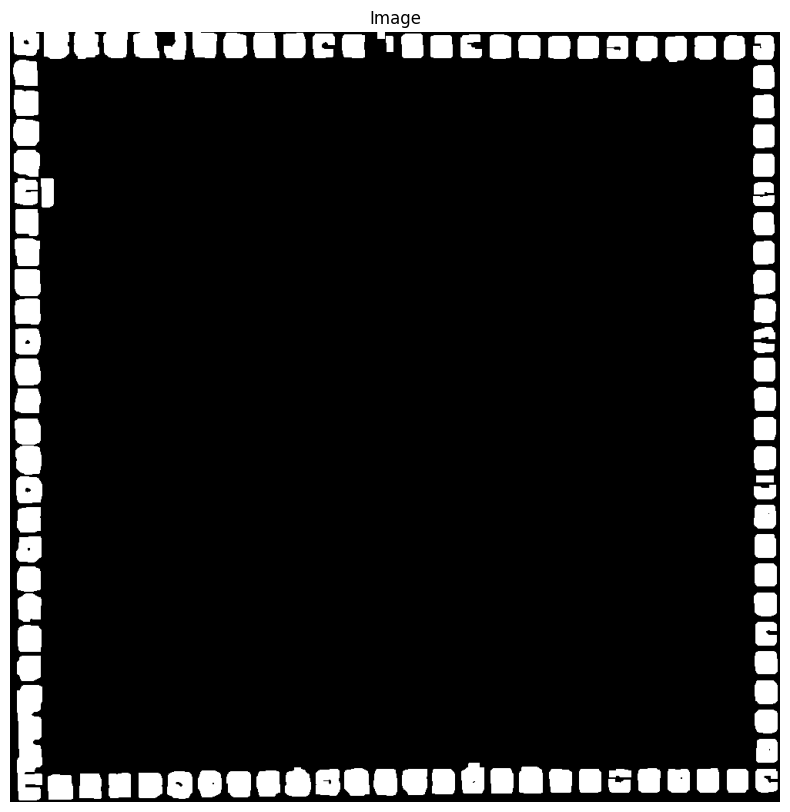

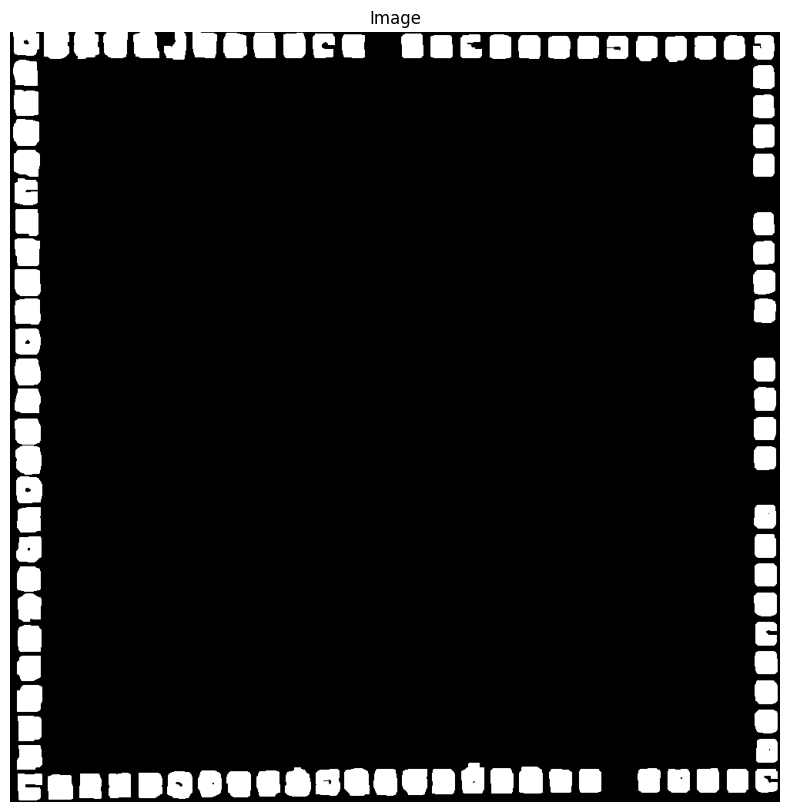

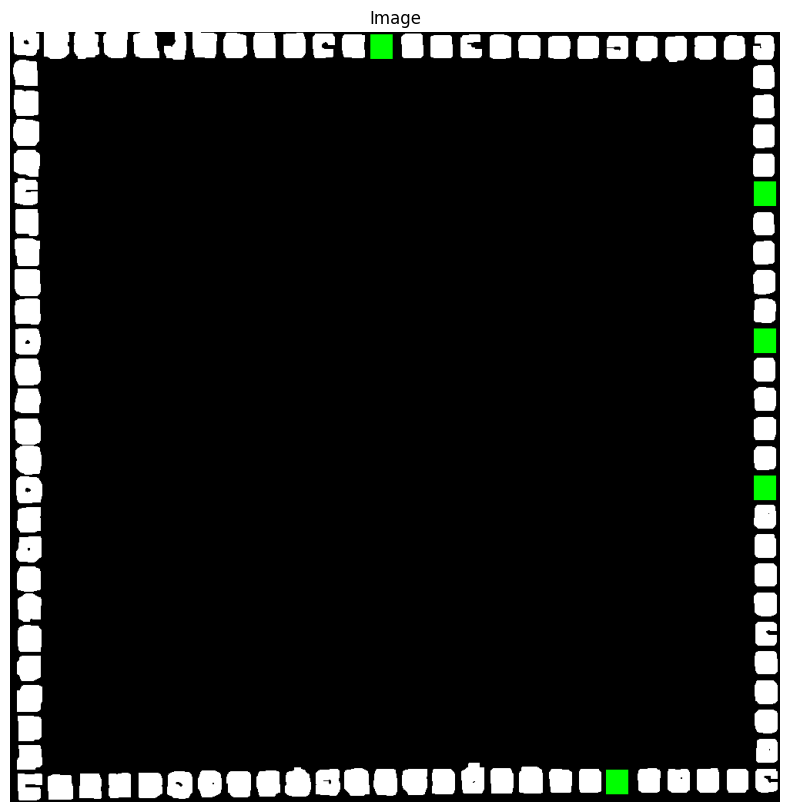

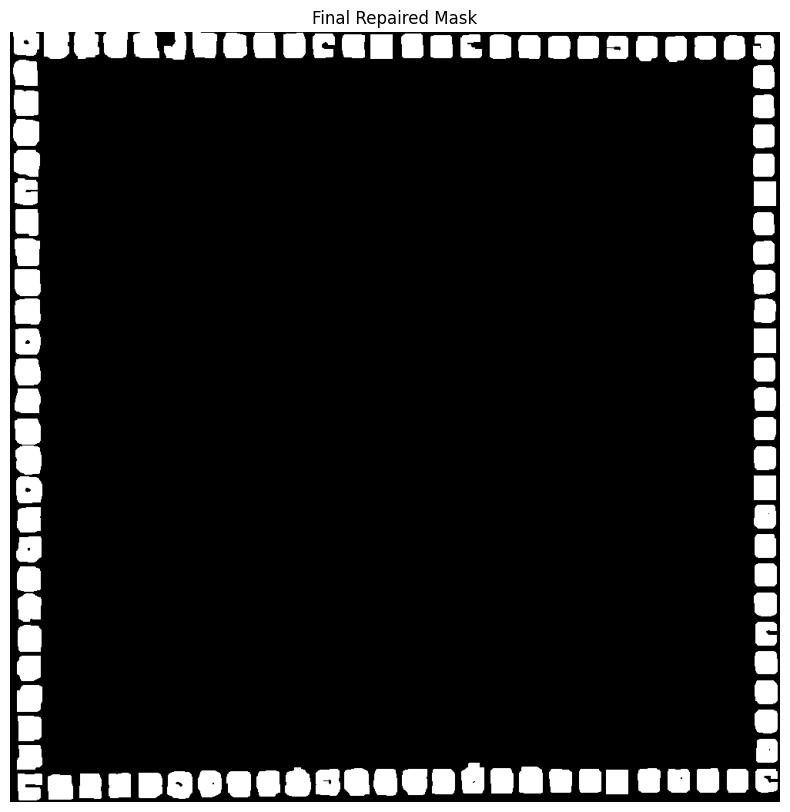

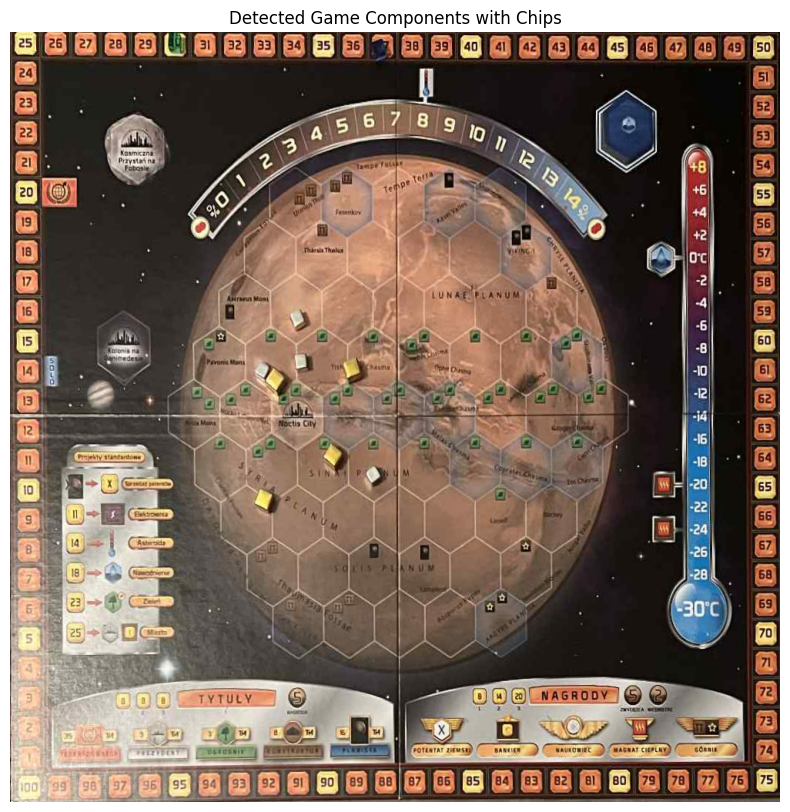

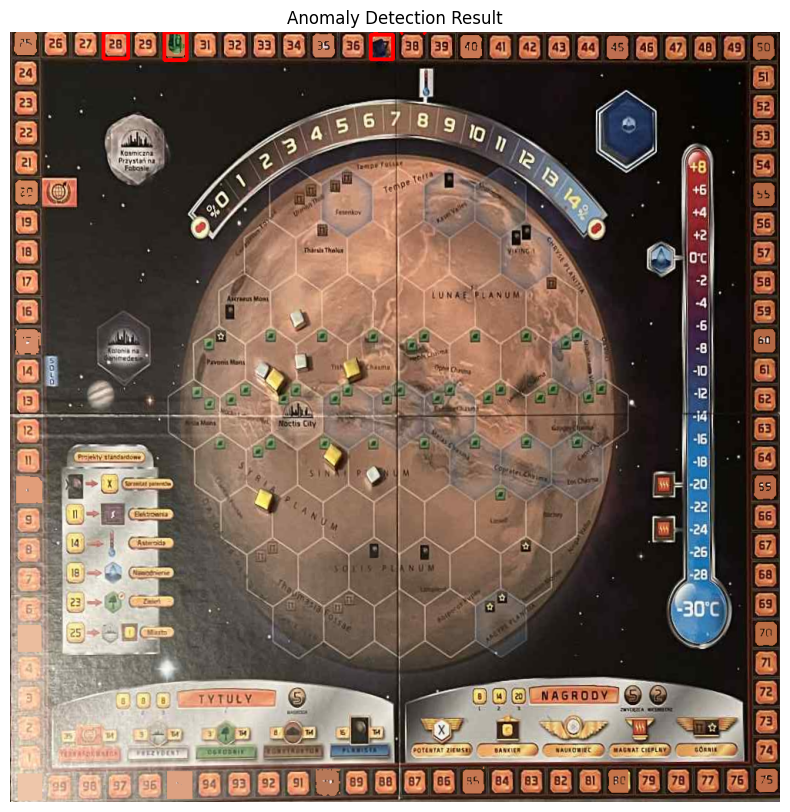

In [212]:
res,map_conts,player_conts = detect_game_components(cv2.imread('maps/mapa21.jpg'))
debug_img = res.copy()
for pc in player_conts:
    cv2.drawContours(debug_img, [pc], -1, (0, 255, 0), 4)
cv2.drawContours(debug_img, [map_conts], -1, (255, 0, 0), 4)
track, warped = isolate_score_track(res, map_conts)
show_inline(warped, title="Isolated Score Track")
player_num = len(player_conts)

perfect_board = crop_floor_by_lab(track)
show_inline(perfect_board)
cleaned_mask = refine_mask(perfect_board)
show_inline(cleaned_mask)


final_mask, debug_view = repair_mask(cleaned_mask, total_pads=100)
final_mask = refine_mask(final_mask)
show_inline(debug_view)
show_inline(final_mask, title="Final Repaired Mask")
res,pads = process_chip_grid(warped, final_mask)
show_inline(res, title="Detected Game Components with Chips")
normalized_vis = normalize_board_colors_robust(res, pads)

result_img, anomalies = detect_anomalies_top_n(
    normalized_vis, 
    pads, 
    neighbor_count=2, 
    top_n=player_num+1
)

show_inline(result_img, title="Anomaly Detection Result")

In [213]:

def extract_inner_map(original_img, pad_data):
    
    if not pad_data:
        print("No pad data provided.")
        return original_img

    
    pad_tl = min(pad_data, key=lambda p: p['x'] + p['y'])
    pad_tr = max(pad_data, key=lambda p: p['x'] - p['y'])
    pad_br = max(pad_data, key=lambda p: p['x'] + p['y'])
    pad_bl = min(pad_data, key=lambda p: p['x'] - p['y'])

    src_tl = [pad_tl['x'] + pad_tl['w'], pad_tl['y'] + pad_tl['h']]
    
    src_tr = [pad_tr['x'], pad_tr['y'] + pad_tr['h']]
    
    src_br = [pad_br['x'], pad_br['y']]
    
    src_bl = [pad_bl['x'] + pad_bl['w'], pad_bl['y']]

    src_pts = np.float32([src_tl, src_tr, src_br, src_bl])

    width_top = np.linalg.norm(src_pts[1] - src_pts[0])
    width_btm = np.linalg.norm(src_pts[2] - src_pts[3])
    max_width = int(max(width_top, width_btm))

    height_lft = np.linalg.norm(src_pts[3] - src_pts[0])
    height_rgt = np.linalg.norm(src_pts[2] - src_pts[1])
    max_height = int(max(height_lft, height_rgt))

    dst_pts = np.float32([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]
    ])

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped_map = cv2.warpPerspective(original_img, M, (max_width, max_height))

    debug_img = original_img.copy()
    cv2.polylines(debug_img, [np.int32(src_pts)], isClosed=True, color=(0, 255, 0), thickness=3)

    return warped_map, debug_img


In [214]:
def correct_orientation(image):
    h, w = image.shape[:2]
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_purple = np.array([125, 50, 50])
    upper_purple = np.array([170, 255, 255])
    
    mask = cv2.inRange(hsv, lower_purple, upper_purple)
    
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return image
        
    largest_cnt = max(contours, key=cv2.contourArea)
    
    M = cv2.moments(largest_cnt)
    if M["m00"] == 0: return image
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    rel_x = cX / w
    rel_y = cY / h
    
    
    if rel_y > 0.60:
        return image
    elif rel_y < 0.40:
        return cv2.rotate(image, cv2.ROTATE_180)
    elif rel_x < 0.40:
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif rel_x > 0.60:
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

    return image

def four_point_transform(image, pts):
    rect = order_points(pts.reshape(4, 2))
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def get_warped_player_boards(original_img, player_contours):
    warped_images = []
    if original_img is None or not player_contours:
        return warped_images

    for contour in player_contours:
        try:
            warped = four_point_transform(original_img, contour)
            
            oriented = correct_orientation(warped)
            
            warped_images.append(oriented)
        except Exception as e:
            print(f"Could not warp/rotate a contour: {e}")
            
    return warped_images


In [215]:
#save empty board for reference
# cv2.imwrite('ref_pb.jpg', player_board_images[0])


 (2, 18, 44,  1, 11, 32),   # Seg 1: Gold Res

( 6, 18, 44,11, 17, 32),  # Seg 2: Gold Prod

(18, 31, 44, 1, 11, 32),   # Seg 3: Iron Res

(18, 30, 44, 11, 16, 32),  # Seg 4: Iron Prod

(31, 43, 44, 1, 11, 32),   # Seg 5: Titan Res

( 30, 42, 44,11, 16, 32),  # Seg 6: Titan Prod

(2, 16, 44,  23, 31, 32),  # Seg 7: Flowers Res 

(2, 16, 44 ,18, 22, 32),  # Seg 8: Flowers Prod

(16, 28, 44, 23, 31, 32),  # Seg 9: Energy Res

( 16, 28, 44,18, 22, 32),  # Seg 10: Energy Prod

(29, 43, 44, 23, 31, 32),  # Seg 11: Heat Res

( 29, 42, 44,18, 23, 32),   # Seg 12: Heat Prod

In [216]:
def segment_player_board(images):
    def get_crop(spec,image):
        x_s, x_e, x_div,y_s, y_e, y_div = spec
        
        y1 = int((y_s / y_div) * h)
        y2 = int((y_e / y_div) * h)
        x1 = int((x_s / x_div) * w)
        x2 = int((x_e / x_div) * w)
        return image[y1:y2, x1:x2]

    specs = [
        (2, 18, 44,  1, 11, 32),   
        ( 6, 18, 44,11, 17, 32),  
        
        (18, 31, 44, 1, 11, 32),   
        (18, 30, 44, 11, 16, 32),  
        
        (31, 43, 44, 1, 11, 32),   
        ( 30, 42, 44,11, 16, 32),  
        
        (2, 16, 44,  23, 31, 32), 
        (2, 16, 44 ,18, 22, 32),  
        
        (16, 28, 44, 23, 31, 32), 
        ( 16, 28, 44,18, 22, 32), 
        
        (29, 43, 44, 23, 31, 32), 
        ( 29, 42, 44,18, 23, 32),  
    ]  

    result_dict ={}
    for idx, image in enumerate(images):
        h, w = image.shape[:2]

        segments=[]
        for spec in specs:
            segments.append(get_crop(spec, image))

        cur_dict = {
            "img": image,
            "resources": {
                "gold":    segments[0], 
                "iron":    segments[2],  
                "titan":   segments[4], 
                "flowers": segments[6], 
                "energy":  segments[8],  
                "heat":    segments[10]  
            },
            "production": {
                "gold":    segments[1],  
                "iron":    segments[3],  
                "titan":   segments[5],  
                "flowers": segments[7],  
                "energy":  segments[9],  
                "heat":    segments[11]  
            }
        }
        result_dict[idx] = cur_dict
    image = ref_board
    h, w = image.shape[:2]
    segments=[]
    for spec in specs:
        segments.append(get_crop(spec, image))
    cur_dict = {
            "img": image,
            "resources": {
                "gold":    segments[0],  
                "iron":    segments[2],
                "titan":   segments[4],  
                "flowers": segments[6],  
                "energy":  segments[8], 
                "heat":    segments[10]  
            },
            "production": {
                "gold":    segments[1],  
                "iron":    segments[3],  
                "titan":   segments[5],  
                "flowers": segments[7],  
                "energy":  segments[9],  
                "heat":    segments[11]  
            }
        }
    result_dict[-1] = cur_dict
    return result_dict


In [217]:


def find_grid_by_big_contour(img,is_gold):
    if img is None: return
    
    debug_img = img.copy()

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(lab, (3, 3), 0)

    closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
    target_percentile = 45
    
    dynamic_thresh_val = np.percentile(closed, target_percentile)
    
    
    thresh = cv2.threshold(closed, dynamic_thresh_val, 255, cv2.THRESH_BINARY)[1]
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours found.")
        return

    big_contour = max(contours, key=cv2.contourArea)
    bx, by, bw, bh = cv2.boundingRect(big_contour)
    cv2.rectangle(debug_img, (bx, by), (bx+bw, by+bh), (255, 0, 0), 2)
    
    if not is_gold:
        num_units_wide = 6 
        unit_width_float = bw / num_units_wide 
        unit_height = bh // 2 

        final_squares = []

        for i in range(num_units_wide):
            x = bx + round(i * unit_width_float)
            x_end = bx + round((i + 1) * unit_width_float)
            w = x_end - x 
            y = by 
            h = unit_height
            final_squares.append((x, y, w, h))

        for i in range(1, 6): 
            x = bx + round(i * unit_width_float)
            x_end = bx + round((i + 1) * unit_width_float)
            w = x_end - x
            y = by + unit_height 
            h = unit_height
            final_squares.append((x, y, w, h))
    else:
        sq_w = bw // 6
        sq_h = bh // 3
        
        final_squares = []
        
        for i in range(5):
            x = bx + int(sq_w*1.1) + (i * sq_w)
            y = by 
            final_squares.append((x, y, sq_w, sq_h))

        for i in range(6):
            x = bx + int(sq_w*0.1)+ (i * sq_w)
            y = by + int(sq_h*1.1)
            final_squares.append((x, y, sq_w, sq_h))

        for i in range(5):
            x = bx + int(sq_w*1.1) + (i * sq_w)
            y = by + int(sq_h*2.2)
            final_squares.append((x, y, sq_w, sq_h))
    for i, (sx, sy, sw, sh) in enumerate(final_squares):
        cv2.rectangle(debug_img, (sx, sy), (sx+sw, sy+sh), (0, 255, 0), 2)
    contour_coords = (bx, by, bw, bh)
    return final_squares,contour_coords




In [218]:

def project_box_by_scaling(ref_img, target_img, ref_box,ref_squares):
    debug_img = target_img.copy()
    h_ref, w_ref = ref_img.shape[:2]
    h_tgt, w_tgt = target_img.shape[:2]

    if h_ref == 0 or w_ref == 0:
        raise ValueError("Reference image has 0 dimension.")

    sx = w_tgt / w_ref
    sy = h_tgt / h_ref

    bx, by, bw, bh = ref_box

    new_bx = int(bx * sx)
    new_by = int(by * sy)
    new_bw = int(bw * sx)
    new_bh = int(bh * sy)
    cv2.rectangle(debug_img, (new_bx, new_by), (new_bx+new_bw, new_by+new_bh), (255, 0, 0), 2)
    new_squares = []
    for (sx_ref, sy_ref, sw_ref, sh_ref) in ref_squares:
        nsx = int(sx_ref * sx)
        nsy = int(sy_ref * sy)
        nsw = int(sw_ref * sx)
        nsh = int(sh_ref * sy)
        new_squares.append((nsx, nsy, nsw, nsh))
    return (new_bx, new_by, new_bw, new_bh),new_squares, (sx, sy)




In [219]:
def detect_color_outlier(img, squares):
    means_lab = []
    
    for i, (x, y, w, h) in enumerate(squares):
        roi = img[y:y+h, x:x+w]
        
        margin_x = int(w * 0)
        margin_y = int(h * 0)
        
        if roi.shape[0] <= 2*margin_y or roi.shape[1] <= 2*margin_x:
            center_roi = roi 
        else:
            center_roi = roi[margin_y:h-margin_y, margin_x:w-margin_x]

        avg_lab = cv2.mean(center_roi)
        means_lab.append(avg_lab)

    means_np = np.array(means_lab)
    median_color = np.median(means_np, axis=0)
    distances = np.linalg.norm(means_np - median_color, axis=1)
    
    outlier_idx = np.argmax(distances)
    max_dist = distances[outlier_idx]

    x, y, w, h = squares[outlier_idx]
    
    cube_roi = img[y:y+h, x:x+w].copy()
    
    h_roi, w_roi = cube_roi.shape[:2]
    my = int(h_roi * 0.3)
    mx = int(w_roi * 0.3)
    center_crop_bgr = cube_roi[my:h_roi-my, mx:w_roi-mx]
    mean_bgr = cv2.mean(center_crop_bgr)[:3]
    mean_bgr = tuple(map(int, mean_bgr)) 

    return outlier_idx, max_dist, mean_bgr

In [220]:
def get_production_levels(player_id,segmented_board,ref_contours):
    production_levels = {}
    colors=[]
    
    for resource, prod_img in segmented_board[player_id]['production'].items():
        ref_img = ref_contours[resource][0]      
        ref_box = ref_contours[resource][1] 

        target_img = segmented_board[player_id]['production'][resource] 
        contours,squares,_ = project_box_by_scaling(ref_img, target_img, ref_box, ref_contours[resource][2])
        outlier_index, confidence,color = detect_color_outlier(target_img, squares)
        colors.append(color)


        debug_img_color = target_img.copy()

        ox, oy, ow, oh = squares[outlier_index]

        cv2.rectangle(debug_img_color, (ox, oy), (ox+ow, oy+oh), (0, 255, 255), 4)
        cv2.putText(debug_img_color, "ODD ONE", (ox, oy - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        if resource == 'gold':
            outlier_index = outlier_index -5
        production_levels[resource] = outlier_index
    bgr_np = np.array(colors)
    median_color_float = np.median(bgr_np, axis=0)
    median_color = tuple(map(int, median_color_float))
    return production_levels, median_color

In [221]:
def visualize_player_color(color_bgr, size=(200, 200)):
    swatch = np.zeros((size[1], size[0], 3), dtype=np.uint8)
    
    swatch[:] = color_bgr
    
    b, g, r = color_bgr
    brightness = (r * 0.299 + g * 0.587 + b * 0.114)
    text_color = (0, 0, 0) if brightness > 127 else (255, 255, 255)
    
    cv2.putText(swatch, "Median Color", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, text_color, 2)
    cv2.putText(swatch, str(color_bgr), (10, 60), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 1)

    return swatch


In [222]:
def filter_anomalies_by_pixel_match(original_img, anomalies, target_color_bgr, top_percent=0.2, debug=False):
    target_pixel = np.uint8([[target_color_bgr]])
    target_hsv = cv2.cvtColor(target_pixel, cv2.COLOR_BGR2HSV)[0][0]
    t_h, t_s, t_v = target_hsv.astype(float)

    scored_candidates = []

    for p in anomalies:
        x, y, w, h = p['x'], p['y'], p['w'], p['h']
        roi = original_img[y:y+h, x:x+w]
        if roi.size == 0: continue

        roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV).astype(float)
        h_map, s_map, v_map = roi_hsv[:,:,0], roi_hsv[:,:,1], roi_hsv[:,:,2]

        diff_h = np.abs(h_map - t_h)
        diff_h = np.minimum(diff_h, 180 - diff_h)
        
        diff_s = np.abs(s_map - t_s)
        diff_v = np.abs(v_map - t_v)

        dist_map = np.sqrt((diff_h * 3.0)**2 + (diff_s)**2 + (diff_v * 0.1)**2)

        flat_dists = dist_map.flatten()
        num_pixels = len(flat_dists)
        num_top = max(1, int(num_pixels * top_percent))
        
        top_k_dists = np.partition(flat_dists, num_top)[:num_top]
        match_score = np.mean(top_k_dists)

        if debug:
            show_inline(visualize_player_color(target_color_bgr, size=(100, 100)))
            threshold_val = np.max(top_k_dists) 
            best_pixels_mask = (dist_map <= threshold_val).astype(np.uint8) * 255
            
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            ax[0].set_title(f"Original ROI (ID: {p.get('id')})")
            
            im = ax[1].imshow(dist_map, cmap='viridis')
            ax[1].set_title("Distance Map (Heatmap)")
            plt.colorbar(im, ax=ax[1])
            
            ax[2].imshow(best_pixels_mask, cmap='gray')
            ax[2].set_title(f"Top {top_percent*100}% Pixels Used")
            
            plt.tight_layout()
            plt.show()

        scored_candidates.append({
            'pad': p,
            'distance': match_score, 
            'original_score': p.get('deviation', 0)
        })
    scored_candidates.sort(key=lambda x: x['distance'])
    return scored_candidates[0]['pad'].get('id', -1) if scored_candidates else -1

In [223]:
def get_crop(spec,image):
        w,h = image.shape[1],image.shape[0]
        x_s, x_e, x_div,y_s, y_e, y_div = spec
        y1 = int((y_s / y_div) * h)
        y2 = int((y_e / y_div) * h)
        x1 = int((x_s / x_div) * w)
        x2 = int((x_e / x_div) * w)
        return image[y1:y2, x1:x2]

In [224]:
def get_ref_ocean(inner_map):
    spec = ( 35, 47, 48, 0, 8, 40)
    ocean_ref = get_crop(spec,inner_map)
    return ocean_ref

In [225]:
def clear_borders(img, border_size=15):
    h, w = img.shape[:2]
    img[:border_size, :] = 0       
    img[h-border_size:, :] = 0      
    img[:, :border_size] = 0        
    img[:, w-border_size:] = 0     
    return img

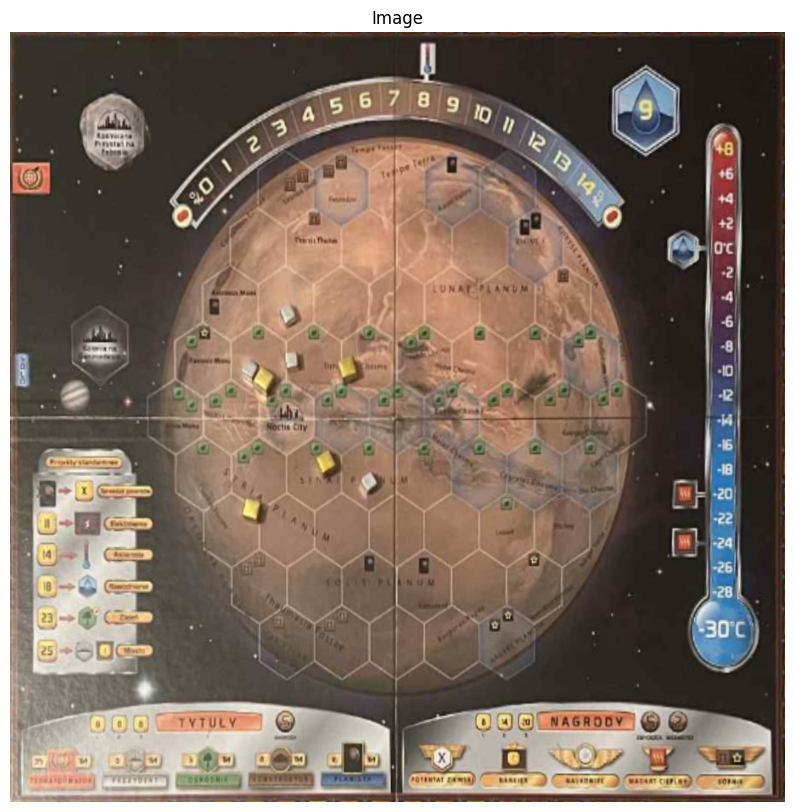

True

In [226]:
i_map = cv2.imread('help/ex_inner_map.png')
show_inline(i_map)
ocean_ref = get_ref_ocean(i_map)
cv2.imwrite('help/ref_ocean.png', ocean_ref)

In [227]:


def fill_mask_holes(mask):
    _, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filled_mask = binary_mask.copy()

    cv2.drawContours(filled_mask, contours, -1, 255, thickness=cv2.FILLED)

    return filled_mask

def check_yellow_presence(hsv_img, tile_mask=None, threshold_ratio=0.02):
    lower_yellow = np.array([15, 50, 50])  
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv_img, lower_yellow, upper_yellow)

    if tile_mask is not None:
        yellow_mask = cv2.bitwise_and(yellow_mask, yellow_mask, mask=tile_mask)
        total_area = cv2.countNonZero(tile_mask)
    else:
        total_area = hsv_img.shape[0] * hsv_img.shape[1]

    yellow_pixels = cv2.countNonZero(yellow_mask)
    return yellow_pixels < 10
def filter_blue_only(img):
        lower_blue = np.array([20, 0, 50])
        upper_blue = np.array([135, 255, 255])

        blue_mask = cv2.inRange(img, lower_blue, upper_blue)

        kernel = np.ones((5,5), np.uint8)
        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel)
        blue_mask = fill_mask_holes(blue_mask)
        blue_only_img = cv2.bitwise_and(img, img, mask=blue_mask)
        return blue_only_img,blue_mask
def keep_only_larges_contour(img):
        h, s, v = cv2.split(img)
        _, thresh = cv2.threshold(v, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return img
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(v)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        result = cv2.bitwise_and(img, img, mask=mask)
        return result,mask


def has_oceans(candidate):
    candidate_hsv = cv2.cvtColor(candidate, cv2.COLOR_BGR2HSV)
    candidate_hsv,_ = filter_blue_only(candidate_hsv)
    candidate_hsv,blue_mask_candidate = keep_only_larges_contour(candidate_hsv)
    return check_yellow_presence(candidate_hsv, tile_mask=blue_mask_candidate)
    

    


In [228]:

def analyze_frame(img):
    map_info = {}
    img_res, map_cnt, player_cnts = detect_game_components(img)
    debug_img = img_res.copy()
    for pc in player_cnts:
        cv2.drawContours(debug_img, [pc], -1, (0, 255, 0), 4)
    cv2.drawContours(debug_img, [map_cnt], -1, (255, 0, 0), 4)
    player_num = len(player_cnts)

    score_track_img, map_flat = isolate_score_track(img_res, map_cnt)
    perfect_board = crop_floor_by_lab(score_track_img)
    perfect_board = clear_borders(perfect_board, border_size=5)
    cleaned_mask = refine_mask(perfect_board)
    final_mask, debug_view = repair_mask(cleaned_mask, total_pads=100)
    result_img, pad_data = process_chip_grid(score_track_img, final_mask)
    normalized_result_img = normalize_board_colors_robust(result_img, pad_data)

    for i, pad in enumerate(pad_data):
        pad['id'] = (i+125)%100
        if pad['id'] == 0:
            pad['id'] = 100
    
    result_img, best_guesses = detect_anomalies_top_n(normalized_result_img, pad_data, top_n=player_num+3)
    final_map, crop_debug = extract_inner_map(map_flat, pad_data)
    map_info['end_condition_ocean'] = has_oceans(get_ref_ocean(final_map))

    player_board_images = get_warped_player_boards(img_res, player_cnts)


    segmented_boards = segment_player_board(player_board_images)
    ref_contours = {}
    for resource in segmented_boards[-1]['production'].items():
        res_name, res_img = resource
        if res_name == 'gold':
            squares,big_contour_coords = find_grid_by_big_contour(res_img, is_gold=True)
        else:  
            squares,big_contour_coords = find_grid_by_big_contour(res_img, is_gold=False)
        ref_contours[res_name] = res_img,big_contour_coords,squares

    player_info = {id: {} for id in range(player_num)}
    for pid in range(player_num):
        prod_levels, color = get_production_levels(pid, segmented_boards, ref_contours)
        player_info[pid]['production_levels'] = prod_levels
        player_info[pid]['color'] = color
        color_swatch_img = visualize_player_color(color)
        player_info[pid]['score'] = filter_anomalies_by_pixel_match(map_flat, best_guesses, player_info[pid]['color'])

    return img_res,player_cnts,map_cnt,player_info,map_info


{0: {'production_levels': {'gold': 5, 'iron': 8, 'titan': 1, 'flowers': 8, 'energy': 3, 'heat': 1}, 'color': (95, 134, 169), 'score': 41}, 1: {'production_levels': {'gold': 1, 'iron': 0, 'titan': 10, 'flowers': 1, 'energy': 6, 'heat': 2}, 'color': (146, 186, 212), 'score': 41}}


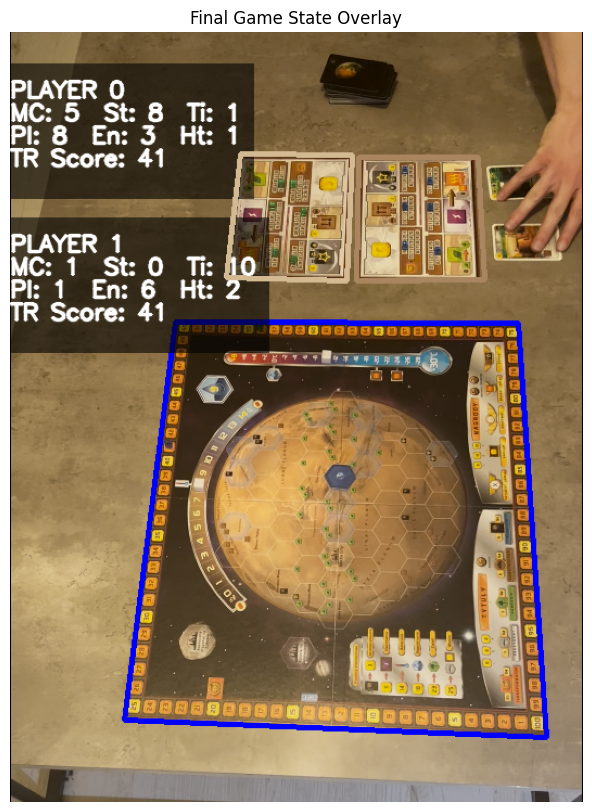

In [229]:


def draw_multiline_text(img, text_lines, position, font_scale=0.6, color=(255, 255, 255), thickness=1):
    font = cv2.FONT_HERSHEY_SIMPLEX
    y_offset = position[1]
    x = position[0]
    
    max_w = 0
    total_h = 0
    line_height = int(30 * font_scale)
    
    for line in text_lines:
        (w, h), _ = cv2.getTextSize(line, font, font_scale, thickness)
        max_w = max(max_w, w)
        total_h += line_height + 5

    pad = 10
    bg_rect = (x - pad, y_offset - line_height - pad, x + max_w + pad, y_offset + total_h - line_height + pad)
    
    overlay = img.copy()
    cv2.rectangle(overlay, (bg_rect[0], bg_rect[1]), (bg_rect[2], bg_rect[3]), (0, 0, 0), -1)
    
    alpha = 0.6
    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

    curr_y = y_offset
    for line in text_lines:
        cv2.putText(img, line, (x, curr_y), font, font_scale, color, thickness, cv2.LINE_AA)
        curr_y += line_height

def overlay_stats(main_map_image, player_contours,map_conts, player_info_dict, map_info):
    final_vis = main_map_image.copy()
    img_h, img_w = final_vis.shape[:2]
    if map_conts is not None:
        cv2.drawContours(final_vis, [map_conts], -1, (255, 0, 0), 3)
    # --- 1. Draw Player Boards Stats ---
    for player_id, stats in player_info_dict.items():
        if player_id >= len(player_contours):
            continue

        cnt = player_contours[player_id]
        x, y, w, h = cv2.boundingRect(cnt)
        text_pos = (x + 220, y) 

        lines = [f"PLAYER {player_id}"]
        if 'production_levels' in stats:
            prod = stats['production_levels']
            lines.append(f"MC: {prod.get('gold', 0)}  St: {prod.get('iron', 0)}  Ti: {prod.get('titan', 0)}")
            lines.append(f"Pl: {prod.get('flowers', 0)}  En: {prod.get('energy', 0)}  Ht: {prod.get('heat', 0)}")
        
        if 'score' in stats:
             lines.append(f"TR Score: {stats['score']}")

        color_bgr = stats.get('color', (0, 0, 255))
        draw_multiline_text(final_vis, lines, (0,60+final_vis.shape[0]*player_id//5), font_scale=0.7, thickness=2)
        cv2.drawContours(final_vis, [cnt], -1, color_bgr, 3)

    # --- 2. Draw Global Map Info (Top Right) ---
    # if map_info:
    #     map_lines = ["GLOBAL PARAMETERS"]
        
    #     # Check for your specific ocean condition key
    #     ocean_end = map_info.get('end_condition_ocean', 0)
    #     map_lines.append(f"oceans still remaining: {ocean_end}")
        
    #     # Add other map_info keys dynamically if they exist later (Temp/Oxygen)
    #     for key, val in map_info.items():
    #         if key != 'end_condition_ocean':
    #             map_lines.append(f"{key.capitalize()}: {val}")

    #     # Calculate position for Top-Right
    #     # We find the width of the box to right-align it
    #     font = cv2.FONT_HERSHEY_SIMPLEX
    #     scale = 0.8
    #     thick = 2
    #     max_line_w = max([cv2.getTextSize(line, font, scale, thick)[0][0] for line in map_lines])
        
    #     # Position: Right edge minus width minus padding
    #     map_text_pos = (img_w - max_line_w - 30, 60) 
        
    #     draw_multiline_text(final_vis, map_lines, map_text_pos, 
    #                         font_scale=scale, color=(0, 255, 255), thickness=thick)
    
    return final_vis
img = cv2.imread('maps/mapa26.jpg')
img_res, player_cnts,map_conts, player_info,map_info = analyze_frame(img)
print(player_info)
final_output = overlay_stats(img_res, player_cnts,map_conts, player_info,map_info)

show_inline(final_output, "Final Game State Overlay")

In [230]:
def draw_obstruction_debug(img, manager):
    overlay = img.copy()
    
    for pid, cnt in manager.stable_player_cnts.items():
        roi_id = f"p_{pid}"
        status = manager.obstruction_status.get(roi_id, "UNKNOWN")
        _draw_roi_debug(overlay, cnt, status, roi_id, manager)

    if manager.stable_map_cnt is not None:
        map_status = manager.obstruction_status.get("map", "UNKNOWN")
        _draw_roi_debug(overlay, manager.stable_map_cnt, map_status, "MAP", manager)
        
        quads = manager._split_contour(manager.stable_map_cnt)
        for k, q_cnt in quads.items():
            q_id = f"map{k}"
            if q_id in manager.debug_scores:
                 _draw_roi_debug(overlay, q_cnt, "Quad", q_id, manager, small=True)

    for pid, center in manager.player_centroids.items():
        if center:
            cx, cy = center
            cv2.line(overlay, (cx - 15, cy), (cx + 15, cy), (0, 0, 255), 2)
            cv2.line(overlay, (cx, cy - 15), (cx, cy + 15), (0, 0, 255), 2)
            
            label = f"ID:{pid} ({cx},{cy})"
            cv2.putText(overlay, label, (cx + 10, cy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 3)
            cv2.putText(overlay, label, (cx + 10, cy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    return overlay

def _draw_roi_debug(img, cnt, status, label_id, manager, small=False):
    color = (0, 255, 0) 
    
    if status == "BLOCKED": color = (0, 0, 255)
    elif status == "BAD_SHAPE": color = (255, 0, 255) 
    elif status == "MISSING": color = (0, 255, 255) 
    
    cv2.drawContours(img, [cnt], -1, color, 2)
    
    scores = ""
    if label_id in manager.debug_scores:
        h, e = manager.debug_scores[label_id]
        scores = f" H:{h:.2f} E:{e:.2f}"
    
    if not small:
        x, y, w, h = cv2.boundingRect(cnt)
        text = f"{label_id}: {status}{scores}"
        cv2.rectangle(img, (x, y-25), (x+len(text)*10, y), color, -1)
        cv2.putText(img, text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)

In [231]:

class DataHarvester:
    def __init__(self, output_dir="dataset/unsorted"):
        self.output_dir = output_dir
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        self.frame_count = 0

    def process(self, frame, motion_mask):
        contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        saved_count = 0
        for i, cnt in enumerate(contours):
            x, y, w, h = cv2.boundingRect(cnt)
            
            if w < 15 or h < 15: continue 
            
            pad = 15
            x1 = max(0, x - pad)
            y1 = max(0, y - pad)
            x2 = min(frame.shape[1], x + w + pad)
            y2 = min(frame.shape[0], y + h + pad)
            
            roi_color = frame[y1:y2, x1:x2]
            
            roi_mask = motion_mask[y1:y2, x1:x2]
            
            base_name = f"frame_{self.frame_count:05d}_cnt_{i}"
            path_base = os.path.join(self.output_dir, base_name)
            
            cv2.imwrite(f"{path_base}_color.jpg", roi_color)
            cv2.imwrite(f"{path_base}_mask.png", roi_mask)
            
            saved_count += 1
            
        self.frame_count += 1
        return saved_count

In [232]:
def find_initial_deck(img, map_cnt, player_cnts):
    debug_img = img.copy()
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    blur = cv2.bilateralFilter(gray, 9, 75, 75)
    
    edged = cv2.Canny(blur, 30, 100)
    
    kernel = np.ones((3, 3), np.uint8) 
    dilated = cv2.dilate(edged, kernel, iterations=2)

    ref_area = (img.shape[0] * img.shape[1])
    if map_cnt is not None:
        ref_area = cv2.contourArea(map_cnt)
    
    margin_thickness = int(0.02 * np.sqrt(ref_area))
    if margin_thickness < 5: margin_thickness = 5

    def mask_out_contour(cnt):
        cv2.drawContours(dilated, [cnt], -1, 0, thickness=margin_thickness*2)
        cv2.drawContours(dilated, [cnt], -1, 0, thickness=-1)

    if map_cnt is not None:
        mask_out_contour(map_cnt)
    if player_cnts:
        for p_cnt in player_cnts:
            mask_out_contour(p_cnt)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    candidates = []
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        
        if area > 500:
             cv2.drawContours(debug_img, [cnt], -1, (0, 0, 255), 1)

        if 2000 < area < 40000:
            
            hull = cv2.convexHull(cnt)
            peri = cv2.arcLength(hull, True)
            approx = cv2.approxPolyDP(hull, 0.04 * peri, True)
            
            if 4 <= len(approx) <= 6:
                x, y, w, h = cv2.boundingRect(approx)
                ar = float(w) / h
                
                if 0.5 < ar < 2.0:
                    candidates.append(hull) 
                    
                    cv2.drawContours(debug_img, [hull], -1, (0, 165, 255), 3)

    best_cnt = None
    if candidates:
        best_cnt = max(candidates, key=cv2.contourArea)
        
        cv2.drawContours(debug_img, [best_cnt], -1, (0, 255, 0), 3)
        cv2.putText(debug_img, "DECK", tuple(best_cnt[0][0]), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    return best_cnt, debug_img

In [233]:
def find_initial_deck(img, map_cnt, player_cnts):
    debug_img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    blur = cv2.bilateralFilter(gray, 9, 75, 75)
    edged = cv2.Canny(blur, 30, 100)
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(edged, kernel, iterations=2)

    ref_area = (img.shape[0] * img.shape[1])
    if map_cnt is not None:
        ref_area = cv2.contourArea(map_cnt)
    
    margin_thickness = int(0.02 * np.sqrt(ref_area))
    if margin_thickness < 5: margin_thickness = 5

    def mask_out_contour(cnt):
        cv2.drawContours(dilated, [cnt], -1, 0, thickness=margin_thickness*2)
        cv2.drawContours(dilated, [cnt], -1, 0, thickness=-1)

    if map_cnt is not None:
        mask_out_contour(map_cnt)
    if player_cnts:
        for p_cnt in player_cnts:
            mask_out_contour(p_cnt)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = []
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 3000 < area < 20000:
            hull = cv2.convexHull(cnt)
            peri = cv2.arcLength(hull, True)
            approx = cv2.approxPolyDP(hull, 0.04 * peri, True)
            
            if 4 <= len(approx) <= 6:
                x, y, w, h = cv2.boundingRect(approx)
                ar = float(w) / h
                if 0.5 < ar < 2.0:
                    candidates.append(hull)
                    cv2.drawContours(debug_img, [hull], -1, (0, 165, 255), 2)

    best_cnt = None
    if candidates:
        best_cnt = max(candidates, key=cv2.contourArea)
        cv2.drawContours(debug_img, [best_cnt], -1, (0, 255, 0), 3)

    return best_cnt, debug_img


In [234]:
def draw_multiline_text(img, text_lines, position, font_scale=0.6, color=(255, 255, 255), thickness=1):
    font = cv2.FONT_HERSHEY_SIMPLEX
    y_offset = position[1]
    x = position[0]
    
    max_w = 0
    total_h = 0
    line_height = int(30 * font_scale) + 5
    
    for line in text_lines:
        (w, h), _ = cv2.getTextSize(line, font, font_scale, thickness)
        max_w = max(max_w, w)
        total_h += line_height

    pad = 10
    bg_y1 = y_offset - int(line_height * 0.7) - pad
    bg_y2 = bg_y1 + total_h + 2 * pad
    
    bg_rect = (x - pad, bg_y1, x + max_w + pad, bg_y2)
    
    overlay = img.copy()
    cv2.rectangle(overlay, (bg_rect[0], bg_rect[1]), (bg_rect[2], bg_rect[3]), (0, 0, 0), -1)
    
    alpha = 0.6
    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

    curr_y = y_offset
    for line in text_lines:
        cv2.putText(img, line, (x, curr_y), font, font_scale, color, thickness, cv2.LINE_AA)
        curr_y += line_height


In [235]:
def overlay_stats(main_map_image, player_contours, map_conts, player_info_dict, map_info):
    final_vis = main_map_image.copy()
    img_h, img_w = final_vis.shape[:2]
    
    if map_conts is not None:
        cv2.drawContours(final_vis, [map_conts], -1, (255, 0, 0), 3)
        
    for player_id, stats in player_info_dict.items():
        if player_id not in player_contours: continue
        cnt = player_contours[player_id]
        
        lines = [f"PLAYER {player_id}"]
        if 'score' in stats: lines.append(f"TR Score: {stats['score']}")
        if 'production_levels' in stats:
            prod = stats['production_levels']
            lines.append(f"MC:{prod.get('gold',0)} S:{prod.get('iron',0)} Ti:{prod.get('titan',0)}")
            lines.append(f"Pl:{prod.get('flowers',0)} E:{prod.get('energy',0)} H:{prod.get('heat',0)}")

        color_bgr = stats.get('color', (0, 0, 255))
        hud_pos = (20, 100 + (final_vis.shape[0] // 3 * player_id))
        draw_multiline_text(final_vis, lines, hud_pos, font_scale=0.7, thickness=2)
        cv2.drawContours(final_vis, [cnt], -1, color_bgr, 3)

    # if map_info:
    #     map_lines = ["GLOBAL PARAMETERS"]
    #     ocean_end = map_info.get('end_condition_ocean', 0)
    #     map_lines.append(f"Oceans: {ocean_end}")
    #     for key, val in map_info.items():
    #         if key != 'end_condition_ocean':
    #             map_lines.append(f"{key.capitalize()}: {val}")

    #     font = cv2.FONT_HERSHEY_SIMPLEX
    #     scale = 0.8
    #     thick = 2
    #     max_line_w = 0
    #     for line in map_lines:
    #         (w, h), _ = cv2.getTextSize(line, font, scale, thick)
    #         if w > max_line_w: max_line_w = w
    #     map_text_pos = (img_w - max_line_w - 40, 60) 
    #     draw_multiline_text(final_vis, map_lines, map_text_pos, font_scale=scale, color=(0, 255, 255), thickness=thick)
    
    return final_vis


In [236]:

def extract_features(img_bgr, mask_gray):
    if img_bgr is None or mask_gray is None: return None
    if img_bgr.shape[:2] != mask_gray.shape[:2]:
        mask_gray = cv2.resize(mask_gray, (img_bgr.shape[1], img_bgr.shape[0]))

    features = []
    
    _, thresh = cv2.threshold(mask_gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours: return None
    cnt = max(contours, key=cv2.contourArea)
    
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    x, y, w, h = cv2.boundingRect(cnt)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    hull_peri = cv2.arcLength(hull, True)

    features.append(float(w) / h if h != 0 else 0)
    
    features.append(area / (w * h) if (w * h) > 0 else 0)
    
    features.append(area / hull_area if hull_area > 0 else 0)
    
    if perimeter > 0:
        compactness = (4 * math.pi * area) / (perimeter ** 2)
        features.append(compactness)
    else:
        features.append(0)

    features.append(hull_peri / perimeter if perimeter > 0 else 0)

    moments = cv2.moments(cnt)
    hu = cv2.HuMoments(moments)
    for i in range(7):
        val = hu[i][0]
        if val != 0: features.append(-1 * np.copysign(1.0, val) * np.log10(abs(val)))
        else: features.append(0)
            
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    mean_ycrcb, _ = cv2.meanStdDev(ycrcb, mask=thresh)
    
    cr_val = mean_ycrcb[1][0]
    cb_val = mean_ycrcb[2][0]
    skin_dist = math.sqrt((cr_val - 154)**2 + (cb_val - 115)**2)
    features.append(skin_dist)

    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mean_hsv, std_hsv = cv2.meanStdDev(hsv, mask=thresh)
    
    features.append(mean_hsv[0][0]) 
    features.append(mean_hsv[1][0]) 
    features.append(std_hsv[0][0])  
    features.append(std_hsv[1][0])  

    return np.array(features)


In [237]:
class HandObstructionDetector:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.total_pixels = width * height
        self.feature_params = dict(
            maxCorners=200, qualityLevel=0.01, minDistance=30, blockSize=3
        )
        self.lk_params = dict(
            winSize=(31, 31),
            maxLevel=3,
            criteria=(
                cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                30,
                0.03,
            ),
        )
        self.ref_gray = None
        self.p0 = None
        self.p_current_guess = None
        self.is_initialized = False
        self.last_valid_M = np.eye(2, 3, dtype=np.float32)
        self.track_mask = np.zeros((height, width), dtype=np.uint8)
        cv2.rectangle(self.track_mask, (0, 0), (width, height), 255, -1)
        border_x = int(width * 0.10)
        border_y = int(height * 0.10)
        cv2.rectangle(
            self.track_mask,
            (border_x, border_y),
            (width - border_x, height - border_y),
            0,
            -1,
        )
        self.fgbg = cv2.createBackgroundSubtractorMOG2(
            history=500, varThreshold=200, detectShadows=False
        )
        self.MIN_SKIN = np.array([0, 133, 77], dtype=np.uint8)
        self.MAX_SKIN = np.array([255, 180, 135], dtype=np.uint8)
        self.hand_cooldown_counter = 0
        self.HAND_PATIENCE = 6
        try:
            with open("hand_classifier.pkl", "rb") as f:
                self.clf = pickle.load(f)
        except FileNotFoundError:
            self.clf = None

    def _add_new_features(self, curr_gray):
        new_pts = cv2.goodFeaturesToTrack(
            curr_gray, mask=self.track_mask, **self.feature_params
        )
        if new_pts is not None:
            new_pts_ref = cv2.transform(new_pts, self.last_valid_M)
            if self.p0 is None:
                self.p0 = new_pts_ref
                self.p_current_guess = new_pts
            else:
                self.p0 = np.concatenate((self.p0, new_pts_ref), axis=0)
                self.p_current_guess = np.concatenate(
                    (self.p_current_guess, new_pts), axis=0
                )


    def process(self, frame):
        curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if not self.is_initialized:
            self.ref_gray = curr_gray.copy()
            self.p0 = cv2.goodFeaturesToTrack(
                self.ref_gray, mask=self.track_mask, **self.feature_params
            )
            if self.p0 is None:
                return frame, np.zeros((self.height, self.width), dtype=np.uint8)
            self.p_current_guess = self.p0.copy()
            self.is_initialized = True
            return frame, np.zeros((self.height, self.width), dtype=np.uint8)

        if self.p_current_guess is None or len(self.p_current_guess) < 100:
            self._add_new_features(curr_gray)

        if self.p0 is not None and len(self.p0) > 0:
            p1, st, err = cv2.calcOpticalFlowPyrLK(
                self.ref_gray,
                curr_gray,
                self.p0,
                nextPts=self.p_current_guess,
                flags=cv2.OPTFLOW_USE_INITIAL_FLOW,
                **self.lk_params
            )
            if p1 is not None:
                status = st.flatten() == 1
                good_new = p1[status]
                good_old = self.p0[status]
                self.p_current_guess = good_new
                self.p0 = good_old
                if len(good_new) > 10:
                    M, inliers = cv2.estimateAffinePartial2D(good_new, good_old)
                    if M is not None:
                        self.last_valid_M = M

        stab_frame = cv2.warpAffine(frame, self.last_valid_M, (self.width, self.height))
        stab_gray = cv2.cvtColor(stab_frame, cv2.COLOR_BGR2GRAY)
        fgmask = self.fgbg.apply(stab_gray, learningRate=0.005)

        if cv2.countNonZero(fgmask) > (self.total_pixels * 0.30):
            return stab_frame, np.zeros((self.height, self.width), dtype=np.uint8)

        _, motion_mask = cv2.threshold(fgmask, 200, 255, cv2.THRESH_BINARY)
        ycrcb = cv2.cvtColor(stab_frame, cv2.COLOR_BGR2YCrCb)
        skin_mask = cv2.inRange(ycrcb, self.MIN_SKIN, self.MAX_SKIN)
        final_mask = cv2.bitwise_and(motion_mask, skin_mask)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, kernel)
        final_mask = cv2.dilate(final_mask, kernel, iterations=3)

        if self.clf is not None and cv2.countNonZero(final_mask) > 0:
            cleaned_mask = np.zeros_like(final_mask)
            cnts, _ = cv2.findContours(
                final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )

            for cnt in cnts:
                x, y, w, h = cv2.boundingRect(cnt)
                if w < 15 or h < 15:
                    continue

                pad = 15
                x1 = max(0, x - pad)
                y1 = max(0, y - pad)
                x2 = min(self.width, x + w + pad)
                y2 = min(self.height, y + h + pad)

                roi_color = stab_frame[y1:y2, x1:x2]
                roi_mask = final_mask[y1:y2, x1:x2]

                features = extract_features(roi_color, roi_mask)
                if features is not None:
                    prediction = self.clf.predict(features.reshape(1, -1))
                    if prediction[0] == 1:
                        cv2.drawContours(cleaned_mask, [cnt], -1, 255, -1)

            final_mask = cleaned_mask

        if cv2.countNonZero(final_mask) > 0:
            self.hand_cooldown_counter = self.HAND_PATIENCE
        elif self.hand_cooldown_counter > 0:
            self.hand_cooldown_counter -= 1

        return stab_frame, final_mask

In [238]:
class GameStateManager:
    def __init__(self, history_len=80):
        # Configuration, Constants
        self.history_len = history_len
        self.MAP_COOLDOWN_LIMIT = 120
        self.COOLDOWN_LIMIT = 80
        self.CONSENSUS_THRESHOLD = 0.60
        self.HIST_THRESH = 0.65
        self.EDGE_THRESH = 0.70
        self.MAX_JUMP_LIMIT = 20.0
        self.DEADBAND = 3.0
        self.ALPHA = 0.10
        self.TRACKING_THRESH = 200
        self.MSG_DURATION = 90

        # State History, Buffers
        self.player_histories = {
            0: deque(maxlen=history_len),
            1: deque(maxlen=history_len),
        }
        self.map_history = deque(maxlen=history_len)
        self.centroid_paths = {0: deque(maxlen=20), 1: deque(maxlen=20)}
        self.map_context_snapshots = {}

        # Geometry, Tracking State
        self.geometry_states = {}
        self.player_centroids = {}
        self.map_centroid = None
        self.ref_hists = {}
        self.ref_edges = {}
        self.ref_areas = {}

        # Stability Output
        self.stable_player_info = {}
        self.stable_map_info = {}
        self.stable_player_cnts = {}
        self.stable_map_cnt = None
        self.pre_obstruction_states = {}

        # Logic Flags, Timers
        self.dirty_flags = {"p_0": False, "p_1": False, "map": False}
        self.cooldown_timers = {"p_0": 0, "p_1": 0, "map": 0}
        self.active_notifications = []

        # Deck, Card Logic
        self.deck_contour = None
        self.deck_locked = False
        self.deck_state = "IDLE"
        self.draw_count = 0
        self.interaction_start_time = 0
        self.verification_timer = 0
        self.pre_draw_card_count = 0
        self.debug_card_contours = []
        self.hand_absent_patience = 0
        self.deck_hist = None
        self.play_state = "STABLE"
        self.play_baseline = {"total": 0, "face_up": 0}
        self.play_timer = 0
        self.held_patience = 0
        self.deck_mean = None
        self.deck_std = None
        self.max_face_up_count = -1
        self.hand_reentry_patience = 0
        
    def _order_points(self, pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)] 
        rect[2] = pts[np.argmax(s)] 
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)] 
        rect[3] = pts[np.argmax(diff)] 
        return rect
    
    def _count_cards_on_table(self, frame, player_cnts_raw, map_cnt_raw):   
        if frame is None: return 0, [], []
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.bilateralFilter(gray, 9, 75, 75)
        edged = cv2.Canny(blur, 30, 100)
        kernel = np.ones((3, 3), np.uint8)
        dilated = cv2.dilate(edged, kernel, iterations=2)
        closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        mask_map = self.stable_map_cnt if self.stable_map_cnt is not None else map_cnt_raw
        
        if self.stable_player_cnts:
            mask_players = list(self.stable_player_cnts.values())
        else:
            mask_players = player_cnts_raw

        img_area = frame.shape[0] * frame.shape[1]
        margin_thickness = int(0.01 * np.sqrt(img_area)) 
        if margin_thickness < 5: margin_thickness = 5

        def mask_out_contour(cnt):
            if cnt is None: return
            cv2.drawContours(closed, [cnt], -1, 0, thickness=margin_thickness*2)
            cv2.drawContours(closed, [cnt], -1, 0, thickness=-1)

        mask_out_contour(mask_map)
        
        if mask_players:
            for pc in mask_players: 
                mask_out_contour(pc)
                
        if self.deck_contour is not None: 
            mask_out_contour(self.deck_contour)
        
        cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        accepted_cnts = []
        rejected_cnts = []
        
        for c in cnts:
            area = cv2.contourArea(c)
            if 3000 < area < 20000:
                hull = cv2.convexHull(c)
                hull_area = cv2.contourArea(hull)
                if hull_area == 0: continue
                solidity = float(area) / hull_area
                peri = cv2.arcLength(hull, True)
                approx = cv2.approxPolyDP(hull, 0.04 * peri, True)
                x, y, w, h = cv2.boundingRect(hull)
                ar = float(w) / h
                
                is_solid = solidity > 0.85 
                is_quad = 4 <= len(approx) <= 6
                is_ar_ok = 0.5 < ar < 2.5
                
                if is_solid and is_quad and is_ar_ok:
                    accepted_cnts.append(hull)
                else:
                    rejected_cnts.append(hull)
                    
        return len(accepted_cnts), accepted_cnts, rejected_cnts
   
    def set_deck_location(self, contour, frame):
        if not self.deck_locked and contour is not None:
            self.deck_contour = contour
            self.deck_locked = True
            
            mask = np.zeros(frame.shape[:2], dtype=np.uint8)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            
            lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
            mean, std = cv2.meanStdDev(lab, mask=mask)
            
            self.deck_mean = mean
            self.deck_std = std
            
            print(f"Deck Locked! Ref Mean: {mean.flatten().astype(int)}")

    def _is_card_face_up(self, frame, contour):
        if not hasattr(self, 'deck_mean') or self.deck_mean is None: 
            return True 
        
        mask = np.zeros(frame.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        
        lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
        curr_mean, curr_std = cv2.meanStdDev(lab, mask=mask)
        
        diff = np.linalg.norm(self.deck_mean - curr_mean)
        
        deck_var = np.mean(self.deck_std)
        curr_var = np.mean(curr_std)
        
        is_face_down = (diff < 45)
        
        # print(f"Diff: {diff:.1f}, Var: {curr_var:.1f} (Deck Var: {deck_var:.1f}) -> {'DOWN' if is_face_down else 'UP'}")
        
        return not is_face_down
    def _update_card_play_logic(self, frame, current_contours):
        if not self.deck_locked: 
            return

        curr_face_up = 0
        for cnt in current_contours:
            if self._is_card_face_up(frame, cnt):
                curr_face_up += 1
        
        if self.max_face_up_count == -1:
            self.max_face_up_count = curr_face_up
            return

        if curr_face_up > self.max_face_up_count:
            self.held_patience += 1
            
            if self.held_patience > 5:
                self._push_notification("card played.")
                
                self.max_face_up_count = curr_face_up
                self.held_patience = 0
        else:
            self.held_patience = 0

    def _update_deck_logic(self, frame, hand_mask, player_cnts, map_cnt):
        if self.deck_contour is None: return

        is_hand_over_deck = self._check_hand_overlap(self.deck_contour, hand_mask)

        if self.deck_state == "IDLE":
            if is_hand_over_deck:
                self.deck_state = "INTERACTION"
                self.interaction_start_time = 0
                count, contours,_ = self._count_cards_on_table(frame, player_cnts, map_cnt)
                self.pre_draw_card_count = count
                self.debug_card_contours = contours 

        elif self.deck_state == "INTERACTION":
            self.interaction_start_time += 1
            
            if is_hand_over_deck:
                self.hand_absent_patience = 0
            else:
                self.hand_absent_patience += 1
                
                if self.hand_absent_patience > 3:
                    
                    if self.interaction_start_time < 5: 
                        self.deck_state = "IDLE"
                    else:
                        self.deck_state = "VERIFYING"
                        self.verification_timer = 75
        
        elif self.deck_state == "VERIFYING":
            self.verification_timer -= 1
            if self.verification_timer % 5 == 0: 
                 
                 _, self.debug_card_contours,_ = self._count_cards_on_table(frame, player_cnts, map_cnt)

            count, acc, rej = self._count_cards_on_table(frame, player_cnts, map_cnt)
            self.debug_card_contours = acc 
            self.debug_rejected_contours = rej
            
            delta = count - self.pre_draw_card_count
            if delta > 0:
                self.draw_count += delta
                self.pre_draw_card_count = self.pre_draw_card_count + delta
                self._push_notification(f"DRAW CONFIRMED (+{delta})")
                self.deck_state = "IDLE"

            if is_hand_over_deck:
                self.hand_reentry_patience += 1
                
                if self.hand_reentry_patience > 3:
                    self.deck_state = "INTERACTION"
                    self.interaction_start_time = 0
                    self.hand_reentry_patience = 0 
            else:
                self.hand_reentry_patience = 0 
            if self.verification_timer < 0 and self.deck_state == "VERIFYING":
                self.deck_state = "IDLE"
    
    def _smooth_geometry(self, raw_cnt, roi_id):
        if roi_id not in self.geometry_states:
            self.geometry_states[roi_id] = {'float_cnt': None, 'snap_counter': 0, 'stable_int': raw_cnt}
        
        state = self.geometry_states[roi_id]
        peri = cv2.arcLength(raw_cnt, True)
        approx = cv2.approxPolyDP(raw_cnt, 0.02 * peri, True)
        
        if len(approx) != 4: return state['stable_int']
        
        pts = approx.reshape(4, 2).astype("float32")
        sorted_pts = self._order_points(pts)
        
        if state['float_cnt'] is None:
            state['float_cnt'] = sorted_pts
            state['stable_int'] = sorted_pts.astype(np.int32).reshape(4, 1, 2)
            return state['stable_int']
        
        deltas = np.linalg.norm(state['float_cnt'] - sorted_pts, axis=1)
        max_move = np.max(deltas)
        
        if max_move > self.MAX_JUMP_LIMIT:
            state['snap_counter'] += 1

            if state['snap_counter'] < 45: return state['stable_int']
            else: state['snap_counter'] = 0
        else: state['snap_counter'] = 0
        
        if max_move < self.DEADBAND: return state['stable_int']
        
        state['float_cnt'] = (state['float_cnt'] * (1 - self.ALPHA)) + (sorted_pts * self.ALPHA)
        state['stable_int'] = state['float_cnt'].astype(np.int32).reshape(4, 1, 2)
        
        return state['stable_int']

    def _get_stable_value(self, values, min_samples=15):
        if not values or len(values) < min_samples: 
            return None 
            
        count = Counter(values)
        most_common, freq = count.most_common(1)[0]
        
        if (freq / len(values)) >= self.CONSENSUS_THRESHOLD: 
            return most_common
            
        return None

    def _get_hist(self, frame, contour):
        mask = np.zeros(frame.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1], mask, [180, 255], [0, 180, 0, 256])
        cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
        return hist

    def _get_edge_density(self, frame, contour, is_map=False):
        x, y, w, h = cv2.boundingRect(contour)
        
        if w <= 0 or h <= 0: return 0
        
        roi = frame[y:y+h, x:x+w]
        
        if roi.size == 0: return 0
        
        mask = np.zeros(roi.shape[:2], dtype=np.uint8)
        roi_cnt = contour - [x, y]
        cv2.drawContours(mask, [roi_cnt], -1, 255, -1)
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        t1, t2 = (30, 100) if is_map else (50, 150)
        edges = cv2.Canny(gray, t1, t2) 
        masked_edges = cv2.bitwise_and(edges, edges, mask=mask)
        total = cv2.countNonZero(mask)
        return (cv2.countNonZero(masked_edges) / total) if total > 0 else 0

    def _check_geometry(self, roi_id, contour):
        area = cv2.contourArea(contour)
        
        if area == 0: return False
        
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        
        if roi_id not in self.ref_areas:
            self.ref_areas[roi_id] = {'area': area, 'ar': aspect_ratio}
            return True
        
        ref = self.ref_areas[roi_id]
        
        if abs(area - ref['area'])/ref['area'] > 0.08 and abs(aspect_ratio - ref['ar'])/ref['ar'] > 0.03: return False 
        return True

    def _check_vision_status(self, frame, roi_id, contour, is_map=False):
        if not self._check_geometry(roi_id, contour): return "BAD_SHAPE"
        curr_hist = self._get_hist(frame, contour)
        curr_edges = self._get_edge_density(frame, contour, is_map)
        
        if roi_id not in self.ref_hists:
            self.ref_hists[roi_id] = curr_hist
            self.ref_edges[roi_id] = curr_edges
            return "OK"
        
        hist_score = cv2.compareHist(self.ref_hists[roi_id], curr_hist, cv2.HISTCMP_CORREL)
        ref_e = self.ref_edges[roi_id] + 1e-6
        edge_ratio = curr_edges / ref_e
        status = "OK"
        
        if hist_score < self.HIST_THRESH:
            if edge_ratio < self.EDGE_THRESH: status = "BLOCKED"
        
        return status

    def _get_centroid(self, cnt):
        M = cv2.moments(cnt)
        
        if M["m00"] != 0: return (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        
        return None

    def _check_hand_overlap(self, contour, hand_mask):
        if contour is None: return False
        
        board_mask = np.zeros_like(hand_mask)
        cv2.drawContours(board_mask, [contour], -1, 255, -1)
        intersection = cv2.bitwise_and(board_mask, hand_mask)
        
        if cv2.countNonZero(board_mask) == 0: return False
        
        return (cv2.countNonZero(intersection) / cv2.countNonZero(board_mask)) > 0

    def _push_notification(self, message):
        self.active_notifications.append({'msg': message, 'timer': self.MSG_DURATION})
    

    def _compare_and_log(self, roi_id, old_state, new_state, old_player_tr_scores=None, new_player_tr_scores=None):
        if not old_state or not new_state: return
        
        if 'production_levels' in old_state and 'production_levels' in new_state:
            old_prod = old_state['production_levels']
            new_prod = new_state['production_levels']
            
            for res, val in old_prod.items():
                if res in new_prod and new_prod[res] != val:
                    self._push_notification(f"{roi_id}: {res} {val} -> {new_prod[res]}")
        
        if roi_id == 'map':
            # for k in ['end_condition_ocean', 'oxygen', 'temperature']:
            #     if k in old_state and k in new_state:
            #         if old_state[k] != new_state[k]:
            #              self._push_notification(f"MAP: {k} {old_state[k]} -> {new_state[k]}")
            if old_player_tr_scores and new_player_tr_scores:
                for pid in [0, 1]:
                    old_s = old_player_tr_scores.get(pid, 0)
                    new_s = new_player_tr_scores.get(pid, 0)
                    if old_s != new_s: self._push_notification(f"PLAYER {pid}: TR Score {old_s} -> {new_s}")

    def _handle_logic(self, roi_id, is_hand_present, vision_status, current_stable_state, fresh_consensus_state):
        effective_trigger = is_hand_present
        
        if effective_trigger:
            if not self.dirty_flags[roi_id]:
                self.pre_obstruction_states[roi_id] = current_stable_state.copy() if current_stable_state else None
                self.dirty_flags[roi_id] = True
                if roi_id == 'map':
                    self.map_history.clear()
                    self.map_context_snapshots = {} 
                    for pid in [0, 1]:
                        p_data = self.stable_player_info.get(pid, {})
                        self.map_context_snapshots[pid] = p_data.get('score', 0)
                elif roi_id.startswith('p_'):
                    pid = int(roi_id.split('_')[1])
                    if pid in self.player_histories: self.player_histories[pid].clear()
            self.cooldown_timers[roi_id] = 0
            return

        if not effective_trigger and self.dirty_flags[roi_id]:
            if vision_status == "OK": self.cooldown_timers[roi_id] += 1
            required_limit = self.MAP_COOLDOWN_LIMIT if roi_id == 'map' else self.COOLDOWN_LIMIT
            if self.cooldown_timers[roi_id] >= required_limit:
                if roi_id.startswith('p_'):
                    pid = int(roi_id.split('_')[1])
                    fresh_consensus_state = self._aggregate_single_player_stats(pid)
                elif roi_id == 'map':
                    fresh_consensus_state = self._aggregate_map_stats()
                old_val = self.pre_obstruction_states.get(roi_id)
                new_val = fresh_consensus_state 
                if roi_id.startswith('p_'): self._compare_and_log(roi_id, old_val, new_val)
                elif roi_id == 'map':
                    new_player_tr_scores = {}
                    for pid in [0, 1]:
                         new_p = self.stable_player_info.get(pid, {})
                         new_player_tr_scores[pid] = new_p.get('score', 0)
                    self._compare_and_log(roi_id, old_val, new_val, old_player_tr_scores=self.map_context_snapshots, new_player_tr_scores=new_player_tr_scores)
                self.dirty_flags[roi_id] = False
                self.cooldown_timers[roi_id] = 0
                self.pre_obstruction_states[roi_id] = None
                if roi_id == 'map': self.map_context_snapshots = {}

    def _aggregate_single_player_stats(self, pid):
        if pid not in self.player_histories or not self.player_histories[pid]: return {}
        history = self.player_histories[pid]
        current_frozen = self.stable_player_info.get(pid, {})
        current_prod = current_frozen.get('production_levels', {})
        current_score = current_frozen.get('score', 0)
        scores = []
        prod_data = {}
        
        for info in history:
            if 'score' in info: scores.append(info['score'])
            if 'production_levels' in info:
                for r, v in info['production_levels'].items():
                    if r not in prod_data: prod_data[r] = []
                    prod_data[r].append(v)
        final = {}
        stable_s = self._get_stable_value(scores)
        final['score'] = stable_s if stable_s is not None else current_score
        final['production_levels'] = {}
        
        for r, vs in prod_data.items():
            stable_p = self._get_stable_value(vs)
            final['production_levels'][r] = stable_p if stable_p is not None else current_prod.get(r, 0)
        return final

    def _aggregate_map_stats(self):
        if not self.map_history: return {}
        agg = {}
        current_map = self.stable_map_info
        
        for info in self.map_history:
            for k, v in info.items():
                if k not in agg: agg[k] = []
                agg[k].append(v)
        final = {}
        
        for k, v in agg.items():
            stable_val = self._get_stable_value(v)
            final[k] = stable_val if stable_val is not None else current_map.get(k, 0)
        return final

    def update(self, frame, hand_mask, player_cnts, map_cnt, player_info, map_info):
        self.active_notifications = [n for n in self.active_notifications if n['timer'] > 0]
        
        for n in self.active_notifications:
            n['timer'] -= 1

        curr_count, curr_acc, curr_rej = self._count_cards_on_table(frame, player_cnts, map_cnt)
        self.debug_card_contours = curr_acc 
        self.debug_rejected_contours = curr_rej 

        self._update_deck_logic(frame, hand_mask, player_cnts, map_cnt)
        self._update_card_play_logic(frame, curr_acc)
        current_cnts_dict = {}
        current_info_dict = {} 
        
        if player_cnts and not self.player_centroids:
            sorted_cnts = sorted(player_cnts, key=lambda c: cv2.boundingRect(c)[0])
            for i, cnt in enumerate(sorted_cnts[:2]):
                cent = self._get_centroid(cnt)
                if cent:
                    self.player_centroids[i] = cent
                    current_cnts_dict[i] = cnt
                    if player_info and i in player_info: current_info_dict[i] = player_info[i]
        elif player_cnts:
            used_contours = set()
            for pid, known_cent in self.player_centroids.items():
                best_dist = 200
                best_idx = -1
                for i, cnt in enumerate(player_cnts):
                    if i in used_contours: continue
                    curr_cent = self._get_centroid(cnt)
                    if not curr_cent: continue
                    dist = np.linalg.norm(np.array(known_cent) - np.array(curr_cent))
                    if dist < best_dist:
                        best_dist = dist 
                        best_idx = i
                if best_idx != -1:
                    current_cnts_dict[pid] = player_cnts[best_idx]
                    used_contours.add(best_idx)
                    if player_info and best_idx in player_info: current_info_dict[pid] = player_info[best_idx]

        target_cnt_for_check = map_cnt if map_cnt is not None else self.stable_map_cnt
        is_hand_map = self._check_hand_overlap(target_cnt_for_check, hand_mask)
        
        if not is_hand_map and map_cnt is not None:
            smoothed_cnt = self._smooth_geometry(map_cnt, 'map')
            vision_status_map = self._check_vision_status(frame, "map", smoothed_cnt, is_map=True)
            if vision_status_map == "OK":
                self.stable_map_cnt = smoothed_cnt
                if self.cooldown_timers['map'] == 25:
                    self.map_history.clear()
                if map_info: self.map_history.append(map_info)
        
        fresh_map_consensus = self._aggregate_map_stats()
        vision_status_map = self._check_vision_status(frame, "map", self.stable_map_cnt, is_map=True)
        self._handle_logic('map', is_hand_map, vision_status_map, self.stable_map_info, fresh_map_consensus)
        
        if not is_hand_map and vision_status_map == "OK" and not self.dirty_flags['map']:
            self.stable_map_info = fresh_map_consensus

        for pid in [0, 1]: 
            roi_id = f"p_{pid}"
            if pid not in self.player_histories: self.player_histories[pid] = deque(maxlen=self.history_len)
            
            if pid in current_cnts_dict:
                cnt = current_cnts_dict[pid]
                is_hand = self._check_hand_overlap(cnt, hand_mask)
                smoothed_cnt = cnt
                
                if not is_hand: 
                    smoothed_cnt = self._smooth_geometry(cnt, roi_id)
                else:
                    if self.geometry_states.get(roi_id): smoothed_cnt = self.geometry_states[roi_id]['stable_int']
                
                curr_cent = self._get_centroid(smoothed_cnt)
                
                if curr_cent and pid in self.player_centroids:
                    anchor = self.player_centroids[pid]
                    alpha = 0.1
                    new_cx = int(anchor[0] * (1-alpha) + curr_cent[0] * alpha)
                    new_cy = int(anchor[1] * (1-alpha) + curr_cent[1] * alpha)
                    self.player_centroids[pid] = (new_cx, new_cy)
                
                vision_status = self._check_vision_status(frame, roi_id, smoothed_cnt, is_map=False)
                
                if vision_status == "OK": self.stable_player_cnts[pid] = smoothed_cnt
                
                if vision_status == "OK" and not is_hand:
                    if self.cooldown_timers[roi_id] == 25:
                        self.player_histories[pid].clear()
                    if pid in current_info_dict: 
                        self.player_histories[pid].append(current_info_dict[pid])
                
                fresh_player_consensus = self._aggregate_single_player_stats(pid)
                curr_frozen = self.stable_player_info.get(pid, {})
                self._handle_logic(roi_id, is_hand, vision_status, curr_frozen, fresh_player_consensus)
                
                if not is_hand and vision_status == "OK" and not self.dirty_flags[roi_id]:
                    self.stable_player_info[pid] = fresh_player_consensus

    def get_stable_state(self):
        return (self.stable_player_cnts, self.stable_map_cnt, self.stable_player_info, self.stable_map_info)


In [239]:
def process_video_offline(input_video_path, output_video_path):
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {input_video_path}")
        return

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    hand_detector = HandObstructionDetector(width, height)
    manager = GameStateManager(history_len=50)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    print(f"Processing {total_frames} frames...")
    
    frames_checked_for_deck = 0
    DECK_SEARCH_LIMIT = 60
    WARMUP_DURATION = 45 

    for frame_idx in tqdm(range(total_frames)): 
        ret, raw_frame = cap.read()
        if not ret: break
        
        stab_frame, hand_mask = hand_detector.process(raw_frame)
        try:
            _, p_cnts, m_cnts, p_info, m_info = analyze_frame(stab_frame) 
        except Exception:
            p_cnts, m_cnts, p_info, m_info = None, None, {}, {}

        if not manager.deck_locked and frames_checked_for_deck < DECK_SEARCH_LIMIT:
            found_deck, debug_view = find_initial_deck(stab_frame, m_cnts, p_cnts)
            if found_deck is not None:
                manager.set_deck_location(found_deck,stab_frame)
            frames_checked_for_deck += 1

        manager.update(stab_frame, hand_mask, p_cnts, m_cnts, p_info, m_info)
        final_frame = stab_frame.copy()
        if frame_idx < WARMUP_DURATION:
            out.write(final_frame)
            continue
        debug_count, debug_acc, debug_rej = manager._count_cards_on_table(stab_frame, p_cnts, m_cnts)
        
        if debug_acc:
            cv2.drawContours(final_frame, debug_acc, -1, (0, 255, 0), 2)
            
            for c in debug_acc:
                is_face_up = manager._is_card_face_up(stab_frame, c)
                
                M = cv2.moments(c)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    
                    dot_color = (0, 255, 255) if is_face_up else (0, 0, 255)
                    cv2.circle(final_frame, (cX, cY), 6, dot_color, -1)
        if manager.deck_contour is not None:
            d_color = (0, 255, 255)
            
            if manager.deck_state == "INTERACTION": d_color = (0, 0, 255) 
            elif manager.deck_state == "VERIFYING": d_color = (0, 165, 255) 
            
            cv2.drawContours(final_frame, [manager.deck_contour], -1, d_color, 2)
            top_pt = tuple(manager.deck_contour[0][0])
            cv2.putText(final_frame, f"Deck: {manager.draw_count} | {manager.deck_state}", 
                       (top_pt[0], top_pt[1] - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, d_color, 2)

        for i, roi_id in enumerate(['p_0', 'p_1', 'map']):
            status_text = "OK"
            color = (0, 255, 0) 
            
            if manager.dirty_flags[roi_id]:
                timer = manager.cooldown_timers[roi_id]
                if timer == 0:
                    status_text = "HAND INTERACTION"
                    color = (0, 0, 255) 
                else:
                    if roi_id == 'map':
                        status_text = f"VERIFYING {timer}/120"
                        color = (0, 165, 255)
                    else:
                        status_text = f"VERIFYING {timer}/80"
                        color = (0, 165, 255)
            
            cv2.putText(final_frame, f"{roi_id}: {status_text}", 
                       (30, height - 150 - i*30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        y_pos = height - 50
        for notif in reversed(manager.active_notifications):
            text = notif['msg']
            cv2.putText(final_frame, text, (width - 600 + 2, y_pos + 2), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 4)
            cv2.putText(final_frame, text, (width - 600, y_pos), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
            y_pos -= 40

        s_p_cnts, s_m_cnt, s_p_info, s_m_info = manager.get_stable_state()
        if s_p_cnts or s_m_cnt:
            final_frame = overlay_stats(final_frame, s_p_cnts, s_m_cnt, s_p_info, s_m_info)

        out.write(final_frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Done! Saved to {output_video_path}")
    

In [240]:
paths = listdir('gameplay/')
for p in paths:
    if isfile(join('gameplay/', p)) and p.endswith('.mp4') and not isfile(join('analyzed_gameplay/', p)):
        print(f"Processing file: {p}")
        process_video_offline(join('gameplay/', p), join('analyzed_gameplay/', p))

Processing file: hard1.mp4
Processing 2946 frames...


  0%|          | 1/2946 [00:00<06:35,  7.44it/s]

Deck Locked! Ref Mean: [ 43 129 138]


100%|█████████▉| 2937/2946 [05:36<00:01,  8.73it/s]

Done! Saved to analyzed_gameplay/hard1.mp4


In [241]:
MODE = "HARVEST" 
VIDEO_PATH = "help/training.mp4" 

if MODE == "GAME":
    manager = GameStateManager()
    analyze_frame = analyze_frame 
else:
    harvester = DataHarvester("dataset/unsorted")

cap = cv2.VideoCapture(VIDEO_PATH)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
detector = HandObstructionDetector(width=width, height=height)

while True:
    ret, frame = cap.read()
    if not ret: break
    
    stab_frame, motion_mask = detector.process(frame)
    
    if MODE == "HARVEST":
        count = harvester.process(stab_frame, motion_mask)
        
        cv2.putText(stab_frame, f"Harvesting: {count} blobs saved", (50, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow("Harvester View", stab_frame)

    else:
        try:
            _, p_cnts, m_cnts, p_info, m_info = analyze_frame(stab_frame)
            manager.update(stab_frame, p_cnts, m_cnts, p_info, m_info)
        except Exception:
            pass
            
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:

DIRS = ['dataset/pos', 'dataset/neg']

def pair_masks():
    print("Synching masks to match color images...")
    
    for folder in DIRS:
        if not os.path.exists(folder): continue
        
        files = os.listdir(folder)
        moved_count = 0
        
        for f in files:
            if f.endswith("_color.jpg"):
                mask_name = f.replace("_color.jpg", "_mask.png")
                
                src_mask = os.path.join("dataset/unsorted", mask_name)
                dst_mask = os.path.join(folder, mask_name)
                
                if os.path.exists(src_mask):
                    shutil.move(src_mask, dst_mask)
                    moved_count += 1
                elif not os.path.exists(dst_mask):
                    print(f"Warning: Mask missing for {f}")

        print(f"Moved {moved_count} matching masks into {folder}")

if __name__ == "__main__":
    pair_masks()

Synching masks to match color images...
Moved 754 matching masks into dataset/pos
Moved 562 matching masks into dataset/neg


In [ ]:


def extract_features(img_bgr, mask_gray):
    if img_bgr is None or mask_gray is None: return None
    if img_bgr.shape[:2] != mask_gray.shape[:2]:
        mask_gray = cv2.resize(mask_gray, (img_bgr.shape[1], img_bgr.shape[0]))

    features = []
    
    _, thresh = cv2.threshold(mask_gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours: return None
    cnt = max(contours, key=cv2.contourArea)
    
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    x, y, w, h = cv2.boundingRect(cnt)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    hull_peri = cv2.arcLength(hull, True)

    features.append(float(w) / h if h != 0 else 0)
    
    features.append(area / (w * h) if (w * h) > 0 else 0)
    
    features.append(area / hull_area if hull_area > 0 else 0)
    
    if perimeter > 0:
        compactness = (4 * math.pi * area) / (perimeter ** 2)
        features.append(compactness)
    else:
        features.append(0)

    features.append(hull_peri / perimeter if perimeter > 0 else 0)

    moments = cv2.moments(cnt)
    hu = cv2.HuMoments(moments)
    for i in range(7):
        val = hu[i][0]
        if val != 0: features.append(-1 * np.copysign(1.0, val) * np.log10(abs(val)))
        else: features.append(0)
            
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    mean_ycrcb, _ = cv2.meanStdDev(ycrcb, mask=thresh)
    
    cr_val = mean_ycrcb[1][0]
    cb_val = mean_ycrcb[2][0]
    skin_dist = math.sqrt((cr_val - 154)**2 + (cb_val - 115)**2)
    features.append(skin_dist)

    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mean_hsv, std_hsv = cv2.meanStdDev(hsv, mask=thresh)
    
    features.append(mean_hsv[0][0]) 
    features.append(mean_hsv[1][0]) 
    
    features.append(std_hsv[0][0]) 
    features.append(std_hsv[1][0]) 
    

    return np.array(features)

def load_dataset():
    X = [] 
    y = [] 
    
    print("Loading Positive samples (Hands)...")
    pos_files = glob("dataset/pos/*_color.jpg")
    for f_path in pos_files:
        mask_path = f_path.replace("_color.jpg", "_mask.png")
        if not os.path.exists(mask_path): continue
        
        img = cv2.imread(f_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        feats = extract_features(img, mask)
        if feats is not None:
            X.append(feats)
            y.append(1)

    print(f"Loaded {len(X)} positive samples.")
    pos_count = len(X)

    print("Loading Negative samples (Noise/Lamp)...")
    neg_files = glob("dataset/neg/*_color.jpg")
    for f_path in neg_files:
        mask_path = f_path.replace("_color.jpg", "_mask.png")
        if not os.path.exists(mask_path): continue
        
        img = cv2.imread(f_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        feats = extract_features(img, mask)
        if feats is not None:
            X.append(feats)
            y.append(0) 

    print(f"Loaded {len(X) - pos_count} negative samples.")
    
    return np.array(X), np.array(y)

if __name__ == "__main__":
    X, y = load_dataset()
    
    if len(X) == 0:
        print("Error: No data found. Check your dataset folder paths.")
        exit()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print("\nTraining AdaBoost Classifier...")
    clf = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=50,
        random_state=42
    )
    clf.fit(X_train, y_train)
    
    print("\nEvaluation on Test Set:")
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=["Noise", "Hand"]))
    
    with open("hand_classifier.pkl", "wb") as f:
        pickle.dump(clf, f)
        
    print("Success! Model saved to 'hand_classifier.pkl'")

Loading Positive samples (Hands)...
Loaded 837 positive samples.
Loading Negative samples (Noise/Lamp)...
Loaded 586 negative samples.

Training AdaBoost Classifier...

Evaluation on Test Set:
              precision    recall  f1-score   support

       Noise       0.95      0.92      0.93       119
        Hand       0.94      0.96      0.95       166

    accuracy                           0.94       285
   macro avg       0.94      0.94      0.94       285
weighted avg       0.94      0.94      0.94       285

Success! Model saved to 'hand_classifier.pkl'
